In [1]:
import os
import glob
import time

import pandas as pd
import numpy as np
import xarray as xr
import datetime


import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
matplotlib.rcParams.update({'font.size': 16})
%matplotlib inline
import cartopy.crs as ccrs
import cartopy

import wrf

from wrfProcessing import *

import sys
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.append(p)

from orographicPrecipitation.precip_model_functions import qsat
SCRATCH='/global/cscratch1/sd/qnicolas/'

import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units

from scipy.integrate import cumtrapz

In [2]:
xr.set_options(display_style='text') 

# Functions, data

In [3]:
def extract_wrfout(simulation_path,nfiles=30): #default extracts 300 days
    files=sorted(glob.glob(simulation_path+'wrfout_d01_197*'))
    files = files[:min(len(files),nfiles)]
    return xr.open_mfdataset(files,combine='nested',concat_dim='Time',parallel=True)
def extract_wrfpro(simulation_path,nfiles=30): #default extracts 300 days
    files=sorted(glob.glob(simulation_path+'wrfpout_d01_197*'))
    files = files[:min(len(files),nfiles)]
    return xr.open_mfdataset(files,combine='nested',concat_dim='Time',parallel=True)

In [4]:
hrchannel = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/')

hrchannel_p = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/')

hrchannelprecip=xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.precip.days0-200.nc')

hrchannel_capecin=xr.open_mfdataset(sorted(glob.glob('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.cape.*')),combine='nested',concat_dim='Time',parallel=True).cape_2d

In [5]:
%time hrpr=hrchannelprecip.isel(Time=slice(200,801)).mean(['Time','south_north']).load()


CPU times: user 322 ms, sys: 1.23 s, total: 1.55 s
Wall time: 1.6 s


In [6]:
hrhgt = hrchannel.HGT.isel(south_north=0,Time=-1).persist()
def plotsection(hgt,figsize=(15,4)):
    fig, ax = plt.subplots(1,1,figsize=figsize)
    ax.set_xlabel("distance west of mountain top (km)")
    ax.set_ylabel("height(m)")
    ax.plot((1635-hgt.west_east)*3,hgt,color='k')
    return ax,ax.twinx()

def f(x):
    return np.sign(x)*x**2

def change_coords_eta(sim,w,center=1635,staggered=0):
    if staggered:
        return w.assign_coords({'distance_from_mtn':(center-w.west_east)*3,'eta_level':sim.ZNW.isel(Time=-1)}).swap_dims({'bottom_top_stag':'eta_level','west_east':'distance_from_mtn'}).persist()
    else:
        return w.assign_coords({'distance_from_mtn':(center-w.west_east)*3,'eta_level':sim.ZNU.isel(Time=-1),'pressure':sim.PB[-1,:,0,:].load()/100}).swap_dims({'bottom_top':'eta_level','west_east':'distance_from_mtn'}).persist()

def change_coords_etav(sim,w,staggered=0):
    if staggered:
        return w.assign_coords({'eta_level':sim.ZNW.isel(Time=-1)}).swap_dims({'bottom_top_stag':'eta_level'}).persist()
    else:
        return w.assign_coords({'eta_level':sim.ZNU.isel(Time=-1),'pressure':sim.PB[-1,:,0,:].load()/100}).swap_dims({'bottom_top':'eta_level'}).persist()


def change_coords_pl(sim,w,center=1635):
    return w.assign_coords({'distance_from_mtn':(center-w.west_east)*3,'pressure':sim.P_PL[0]/100}).swap_dims({'num_press_levels_stag':'pressure','west_east':'distance_from_mtn'}).persist()

def change_coords_press(sim,w):
    return w.assign_coords({'pressure':sim.P_PL[0]/100}).swap_dims({'num_press_levels_stag':'pressure'})

def change_coords_sfc(w,center=1635):
    return w.assign_coords({'distance_from_mtn':(center-w.west_east)*3}).swap_dims({'west_east':'distance_from_mtn'}).persist()


In [11]:
umean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.U_PL.days50-200.nc')
vmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.V_PL.days50-200.nc')
wmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.W_PL.days50-200.nc')
rhomean = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.RHO_PL.days50-200.nc')
qmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.Q_PL.days50-200.nc')
tmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.T_PL.days50-200.nc')
zmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.GHT_PL.days50-100.nc')


In [12]:
umean   = umean.where(umean > -30)  
vmean   = vmean.where(vmean > -30)  
wmean   = wmean.where(wmean > -30)  
rhomean = rhomean.where(rhomean >0.)  
qmean   = qmean.where(qmean >0.)  
tmean   = tmean.where(tmean >100.)  
omegamean = -9.81*rhomean*wmean
zmean   = zmean.where(zmean >=0.)  

In [13]:
umean_p = change_coords_pl(hrchannel_p,umean)[1:-4]
omegamean_p = change_coords_pl(hrchannel_p,omegamean)[1:-4]
tmean_p = change_coords_pl(hrchannel_p,tmean)[1:-4]
zmean_p = change_coords_pl(hrchannel_p,zmean)[1:-4]
qmean_p = change_coords_pl(hrchannel_p,qmean)[1:-4]

In [14]:
wmean_s = change_coords_eta(hrchannel,xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.W.days50-200.nc'),staggered=True)
wdrymean_s = change_coords_eta(hrchannel,xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/diags/wrf.W.days50-100.nc'),staggered=True)
tmean_s   = change_coords_eta(hrchannel,xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.TEMP.days50-200.nc')  )
rhomean_s = change_coords_eta(hrchannel,xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.RHO.days50-200.nc')   )
qmean_s   = change_coords_eta(hrchannel,xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.QVAPOR.days50-200.nc'))


In [16]:
def interp_eta_to_pressure(ds,var,staggered=1,plevs=None):
    """Make sure eta_level is the first dimension"""
    if plevs is None:
        plevs= np.arange(125.,990.,20.)
    rep=np.zeros((len(plevs),len(var[0])))
    PB_rev = np.array(ds.PB[0,:,0]+ds.P[-20:].mean(['Time','south_north']))[::-1]
    var_rev=np.array(var)[::-1]
    if staggered:
        i=0
        ZNW = np.array(ds.ZNW[0])[::-1]
        ZNU=  np.array(ds.ZNU[0])[::-1]
        for i in range(len(var[0])):
            PB_rev_stag = np.interp(ZNW,ZNU,PB_rev[:,i])
            rep[:,i]=np.interp(plevs*100,PB_rev_stag,var_rev[:,i])
            rep[plevs*100>PB_rev_stag[-1],i]=np.nan
    else:
        for i in range(len(var[0])):
            rep[:,i]=np.interp(plevs*100,PB_rev[:,i],var_rev[:,i])
            rep[plevs*100>PB_rev[-1,i],i]=np.nan
    return xr.DataArray(rep[::-1],coords={'pressure':plevs[::-1],'distance_from_mtn':var.distance_from_mtn},dims=['pressure','distance_from_mtn'])

In [8]:
dryumean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/diags/wrf.U_PL.days50-100.nc')[::-1]
drywmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/diags/wrf.W_PL.days50-100.nc')[::-1]
dryrhomean = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/diags/wrf.RHO_PL.days50-100.nc')[::-1]
drytmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/diags/wrf.T_PL.days50-100.nc')[::-1]
dryqmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/diags/wrf.Q_PL.days50-100.nc')[::-1]

dryumean     = dryumean.where(dryumean >-30.)
drywmean     = drywmean.where(drywmean > -10)
dryrhomean   = dryrhomean.where(dryrhomean >0.)
drytmean     = drytmean.where(drytmean >100.)
dryqmean     = dryqmean.where(dryqmean >0.)
dryomegamean = -9.81*dryrhomean*drywmean

dryumean_p     = change_coords_sfc(dryumean)[4:]
drytmean_p     = change_coords_sfc(drytmean)[4:]
dryqmean_p     = change_coords_sfc(dryqmean)[4:]
dryomegamean_p = change_coords_sfc(dryomegamean)[4:]
drythetamean_p = (drytmean_p*(drytmean_p.pressure/1e3)**(-0.286))

In [17]:
dryhrchannel = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/')
dryzmean_s=change_coords_eta(dryhrchannel,xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/diags/wrf.Z.days50-100.nc'),staggered=1)
dryzmean_p=interp_eta_to_pressure(dryhrchannel,dryzmean_s,staggered=1,plevs=omegamean_p.pressure)[::-1]

# The theory

As a reminder, our starting set of equations is composed of the QTCM thermodynamic & moisture equations.

$$
\begin{align} 
\mathbf{u}_0\cdot\nabla T_m  &+ \omega_m\dfrac{\partial s_0}{\partial p} = Q_c - R \\
\mathbf{u}_0\cdot\nabla q_m  &+ \omega_m\dfrac{\partial q_0}{\partial p} = Q_q + E
\end{align} 
$$

where the subscript $m$ denotes a moist perturbation (the flow is supposed to be a sum of a dry perturbation and a moist perturbation that feeds on the dry one, but doesn't interact back). Assuming WTG, vertically averaging and subsituting for $\omega_m$ gives
$$ \mathbf{u}_0 \cdot \nabla \hat q_m - \hat Q_q -\hat E - \dfrac{M_q}{M_s}(\hat Q_c-\hat R) = 0$$
Using the energy constraint $\hat Q_c+\hat Q_q = 0$, we get
$$ \mathbf{u}_0 \cdot \nabla \hat q_m  + \dfrac{M_h}{M_s}\left(\hat Q_c - \dfrac{M_s \hat E - M_q \hat R}{M_h}\right)= 0$$

We now introduce the $q - T$ convective closure, $\hat Q_c = \dfrac{\hat q'}{\tau_q}-\dfrac{\hat T'}{\tau_T}$. Here, $\hat q'$ denotes the free-tropospheric averaged moisture perturbation and $\hat T'$ the bottom-free-tropospheric averaged temperature perturbation. So strictly speaking, 
$$\hat q' = \hat q_m + \hat q_d ~~\mathrm{ and }~~ \hat T' = \hat T_m + \hat T_d= \hat T_d$$
In the first part of this notebook, we will neglect the $\hat q_d$ contribution, so that $$\hat Q_c = \dfrac{\hat q_m}{\tau_q}-\dfrac{\hat T_d}{\tau_T}$$
The temperature perturbation imposed by the dry mountain wave exerts a control on convection by modulating the free-tropospheric buoyancy of convective plumes.

Casting our equation in 1D and plugging the convective closure, we finally obtain
$$\dfrac{\mathrm{d}\hat q_m}{\mathrm{d}x} + \dfrac{\hat q_m-\hat q_{m0}}{L_q} - \dfrac{\hat T_d (x)}{L_T} = 0$$

where $L_q = u_0 \tau_q \frac{M_s}{M_h}$, $L_T = u_0 \tau_T \frac{M_s}{M_h}$ and $\hat q_{m0} = \tau_q\frac{M_s \hat E - M_q \hat R}{M_h}$

One can also derive an equation for $\hat Q_c$, which we will interchangeably call precipitation $P$:
$$\dfrac{\mathrm{d} P}{\mathrm{d}x} + \dfrac{P-P_0}{L_q} + \dfrac{1}{\tau_T}\dfrac{\mathrm{d}\hat T_d}{\mathrm{d}x} = 0$$

where $P_0 = \frac{M_s \hat E - M_q \hat R}{M_h}$

# Temperature perturbations - $\hat T_d(x)$

In [18]:
def hatprime(var,idx1,idx2):
    varhat = var[idx1:idx2].integrate('pressure')/(var.pressure[idx2]-var.pressure[idx1])
    return varhat - varhat[2200:2400].mean('distance_from_mtn')

tmean_p_hat_prime         = hatprime(tmean_p,4,11)
tmean_p_hat_prime_halft   = hatprime(tmean_p,4,15)
tmean_p_hat_prime_fullt   = hatprime(tmean_p,4,20)
drytmean_p_hat_prime      = hatprime(drytmean_p,4,11)

Text(0.5, 1.0, '')

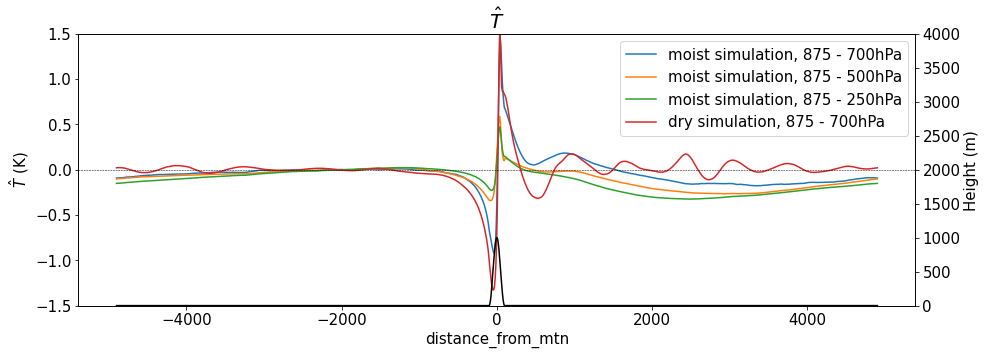

In [56]:
matplotlib.rcParams.update({'font.size': 15})
_,ax=plt.subplots(1,1,figsize=(15,5))

tmean_p_hat_prime.plot(ax=ax,label='moist simulation, 875 - 700hPa')
tmean_p_hat_prime_halft.plot(ax=ax,label='moist simulation, 875 - 500hPa')
tmean_p_hat_prime_fullt.plot(ax=ax,label='moist simulation, 875 - 250hPa')
drytmean_p_hat_prime.plot(ax=ax,label='dry simulation, 875 - 700hPa')

ax.axhline(0.,color='k',linestyle='--',linewidth=0.5)
ax.legend()
ax.set_ylim(-1.5,1.5)
ax.set_ylabel(r'$\hat T$ (K)')
ax.set_title(r"$\hat T$",fontsize=20)

ax2=ax.twinx()
change_coords_sfc(hrhgt).plot(ax=ax2,color='k',label='Surface elevation')
ax2.set_ylim( 0,4000)
ax2.set_ylabel("Height (m)")
ax2.set_title("")

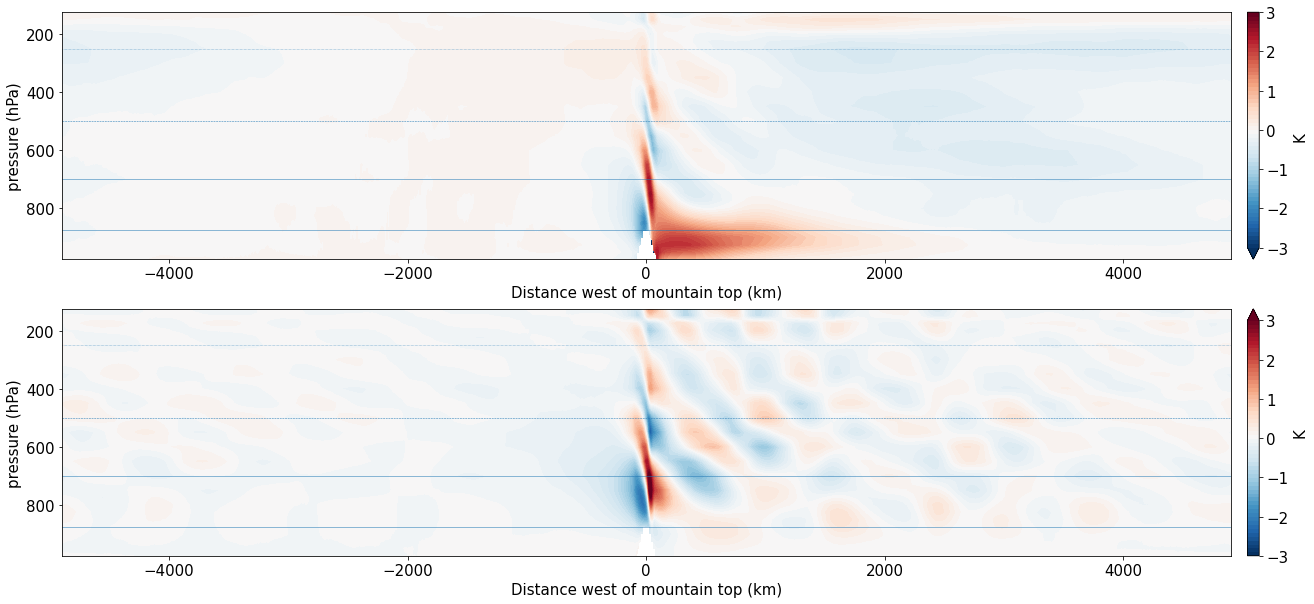

In [63]:
fig,axs=plt.subplots(2,1,figsize=(25,10))
tlevs=np.arange(-3,3.01,0.1)
tticks=np.arange(-3,3.01,1)

ax=axs[0]
(tmean_p-tmean_p[:,2200:2400].mean('distance_from_mtn')).plot.contourf(ax=ax,yincrease=False,levels=tlevs,cbar_kwargs={'ticks':tticks,'label':'K','pad':.012})

ax=axs[1]
(drytmean_p-drytmean_p[:,2200:2400].mean('distance_from_mtn')).plot.contourf(ax=ax,yincrease=False,levels=tlevs,cbar_kwargs={'ticks':tticks,'label':'K','pad':.012})


for ax in axs:
    ax.set_xlabel("Distance west of mountain top (km)")
    ax.set_ylabel("pressure (hPa)")
    ax.set_xlim(-4900,4900)
    ax.axhline(875.,linewidth=0.5)
    ax.axhline(700.,linewidth=0.5)
    ax.axhline(500.,linewidth=0.5,linestyle='--')
    ax.axhline(250.,linewidth=0.5,linestyle=':')


# Solving for P with fixed evaporation & radiation

The following quantities are needed :
 - $P_0$, the RCE precipitation, is fixed at 4.5 mm/day
 - $\tau_q = 6$ hours and $\tau_T = 3$ hours, as in Ahmed et al. 2020
 - $M_s/M_h = 5$, hence $L_T \simeq 500$ km and $L_q \simeq 1000$ km

In [ ]:
#def precip(qhat,That,tauq,tauT):
#    """Compute a precipitation in mm/day (Pr = CAPE/tau_c/LatentHeat)"""
#    Lc = 2.26e6 #latent heat of condensation in J/kg
#    M = 8e3 #mass of troposphere in kg/m2
#    conversion = 86400
#    return conversion * M * (qhat/tauq - That/tauT) / Lc
#def qhat_analytical_T(x,Lq,LT,qhat0,That):
#    f = cumtrapz(np.exp(x/Lq)*That/LT,x,initial=0)
#    idx2000 = 0#np.argmin(np.array(x+2000))
#    return qhat0+np.exp(-x/Lq)*(f-f[idx2000])
#qhat = qhat_analytical_T(x,Lq,LT,qhat0,cp*np.array(tmean_p_hat_prime)[::-1])
#pr_analytical=precip(np.array(qhat),cp*np.array(tmean_p_hat_prime)[::-1],tauq,tauT)

In [17]:
from scipy.integrate import cumtrapz

def domain():
    return np.linspace(0,width,100000)

def precip_analytical_T(x,Lq,tauT,P0,That,alpha=0):
    Lc = 2.26e6 #latent heat of condensation in J/kg
    M = 8e3 #mass of troposphere in kg/m2
    conversion = 86400
    f = cumtrapz(np.exp(x/Lq)*(P0/Lq*alpha-np.gradient(That,x)/tauT),x,initial=0)
    return conversion * M / Lc * (P0+np.exp(-x/Lq)*f)


In [18]:
# x from simulation
hrdist=(1635-hrhgt.west_east)*3
x = 1000*hrdist[::-1]

cp=1004.

qhat0 = 320      #J/kg
tauq  = 6*3600   #s
tauT  = 3*3600   #s
u0    = 10       #m/s
Lq    = 5*u0*tauq #m
LT    = 5*u0*tauT #m

In [19]:
def plot_pr(lw=2,prlim=30):
    matplotlib.rcParams.update({'font.size': 15})
    _,axpr=plt.subplots(1,1,figsize=(15,5))
    axca=axpr.twinx()
    
    axca.plot(hrdist,hrhgt,color='k',label='Surface elevation',linewidth=2)
    axpr.plot(hrdist,hrpr,label="WRF P",color='g',linewidth=lw)
    axpr.axhline(hrpr[2000:3000].mean(),color='g',linestyle='--',linewidth=1)

    axca.set_xlim( -5000,5000)
    axca.set_ylim( 0,5000)
    axca.set_ylabel("Height (m)")
    
    axpr.set_ylim(0,prlim)
    axpr.set_ylabel('P (mm/day)')
    return axpr

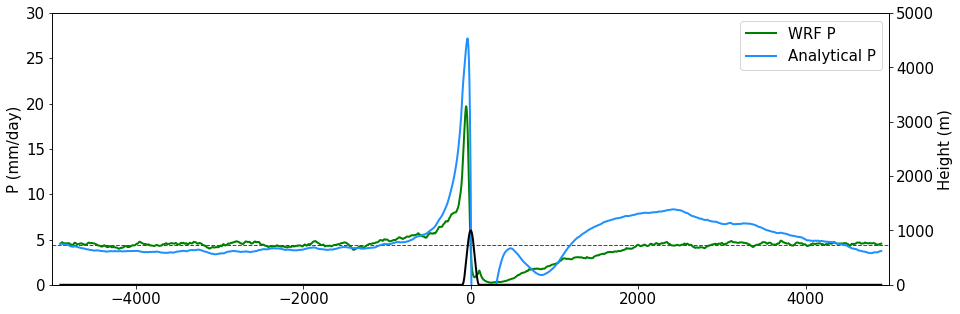

In [65]:
axpr = plot_pr()
pr_analytical=precip_analytical_T(x,Lq,tauT,qhat0/tauq,cp*np.array(tmean_p_hat_prime)[::-1])
axpr.plot(hrdist,pr_analytical[::-1],label="Analytical P",color='dodgerblue',linewidth=2)

axpr.legend()

Text(0.5, 1.0, 'Sensitivity to a change in $\\hat T$')

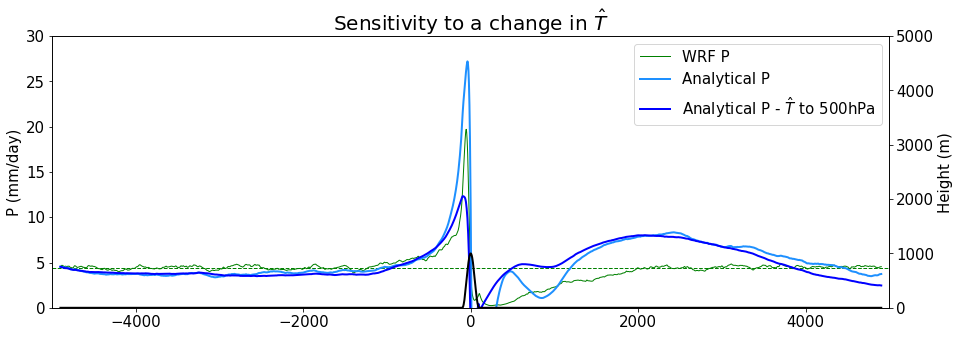

In [67]:
axpr = plot_pr(lw=1)

pr_analytical=precip_analytical_T(x,Lq,tauT,qhat0/tauq,cp*np.array(tmean_p_hat_prime)[::-1])
axpr.plot(hrdist,pr_analytical[::-1],label="Analytical P",color='dodgerblue',linewidth=2)

pr_analytical=precip_analytical_T(x,Lq,tauT,qhat0/tauq,cp*np.array(tmean_p_hat_prime_halft)[::-1])
axpr.plot(hrdist,pr_analytical[::-1],label=r"Analytical P - $\hat T$ to 500hPa",color='b',linewidth=2)

axpr.legend()
axpr.set_title(r"Sensitivity to a change in $\hat T$",fontsize=20)

Text(0.5, 1.0, 'Sensitivity to a change in $\\tau_T$')

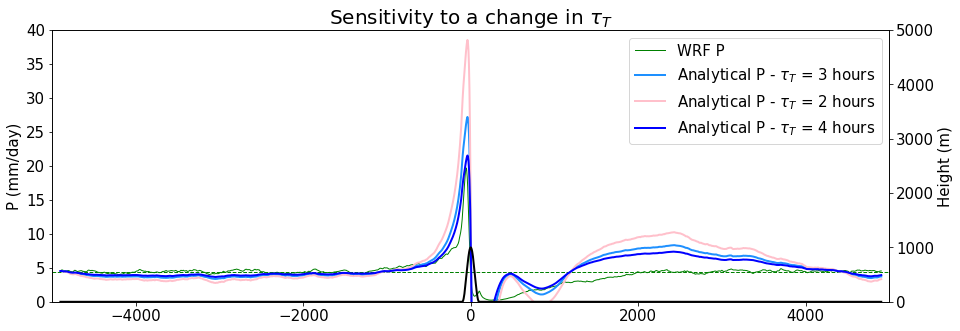

In [71]:
axpr = plot_pr(lw=1,prlim=40)

pr_analytical=precip_analytical_T(x,Lq,tauT,qhat0/tauq,cp*np.array(tmean_p_hat_prime)[::-1])
axpr.plot(hrdist,pr_analytical[::-1],label=r"Analytical P - $\tau_T$ = 3 hours",color='dodgerblue',linewidth=2)

pr_analytical=precip_analytical_T(x,Lq,2*3600,qhat0/tauq,cp*np.array(tmean_p_hat_prime)[::-1])
axpr.plot(hrdist,pr_analytical[::-1],label=r"Analytical P - $\tau_T$ = 2 hours",color='pink',linewidth=2)

pr_analytical=precip_analytical_T(x,Lq,4*3600,qhat0/tauq,cp*np.array(tmean_p_hat_prime)[::-1])
axpr.plot(hrdist,pr_analytical[::-1],label=r"Analytical P - $\tau_T$ = 4 hours",color='b',linewidth=2)

axpr.legend()
axpr.set_title(r"Sensitivity to a change in $\tau_T$",fontsize=20)

Text(0.5, 1.0, 'Sensitivity to a change in $L_q$')

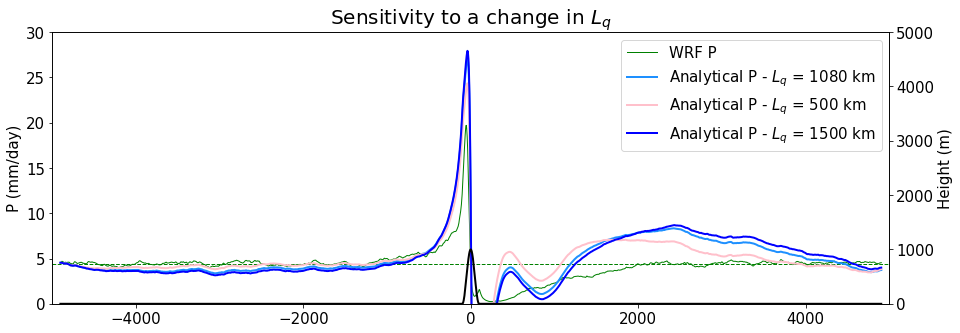

In [73]:
axpr = plot_pr(lw=1)

pr_analytical=precip_analytical_T(x,Lq,tauT,qhat0/tauq,cp*np.array(tmean_p_hat_prime)[::-1])
axpr.plot(hrdist,pr_analytical[::-1],label=r"Analytical P - $L_q$ = 1080 km",color='dodgerblue',linewidth=2)

pr_analytical=precip_analytical_T(x,500e3,tauT,qhat0/tauq,cp*np.array(tmean_p_hat_prime)[::-1])
axpr.plot(hrdist,pr_analytical[::-1],label=r"Analytical P - $L_q$ = 500 km",color='pink',linewidth=2)

pr_analytical=precip_analytical_T(x,1500e3,tauT,qhat0/tauq,cp*np.array(tmean_p_hat_prime)[::-1])
axpr.plot(hrdist,pr_analytical[::-1],label=r"Analytical P - $L_q$ = 1500 km",color='b',linewidth=2)

axpr.legend()
axpr.set_title(r"Sensitivity to a change in $L_q$",fontsize=20)

Text(0.5, 1.0, 'Sensitivity to a change in $P_0$')

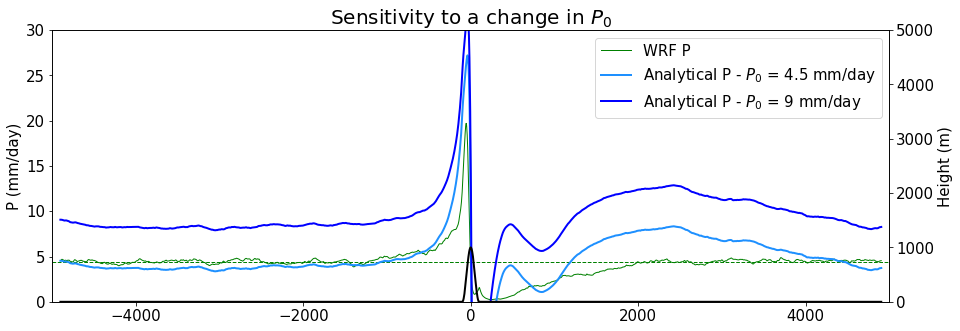

In [75]:
axpr = plot_pr(lw=1)

pr_analytical=precip_analytical_T(x,Lq,tauT,qhat0/tauq,cp*np.array(tmean_p_hat_prime)[::-1])
axpr.plot(hrdist,pr_analytical[::-1],label=r"Analytical P - $P_0$ = 4.5 mm/day",color='dodgerblue',linewidth=2)

pr_analytical=precip_analytical_T(x,Lq,tauT,qhat0/tauq*2,cp*np.array(tmean_p_hat_prime)[::-1])
axpr.plot(hrdist,pr_analytical[::-1],label=r"Analytical P - $P_0$ = 9 mm/day",color='b',linewidth=2)

axpr.legend()
axpr.set_title(r"Sensitivity to a change in $P_0$",fontsize=20)

# Solving for P with varying evaporation & radiation

Recall the precipitation equation:
$$\dfrac{\mathrm{d} P}{\mathrm{d}x} + \dfrac{P-P_0}{L_q} + \dfrac{1}{\tau_T}\dfrac{\mathrm{d}\hat T_d}{\mathrm{d}x} = 0$$
where $P_0 = \frac{M_s \hat E - M_q \hat R}{M_h}$

If we note $\hat E = E_0(1 + e'(x))$, $\hat R = E_0(1 + r'(x))$, then 
$$P_0 = E_0\left(1 + \dfrac{M_s e' - M_q r'}{M_h}\right) =:E_0(1+\alpha(x))$$
Which leads to
$$\dfrac{\mathrm{d} P}{\mathrm{d}x} + \dfrac{P-E_0}{L_q} - \dfrac{E_0}{L_q}\alpha(x) +  \dfrac{1}{\tau_T}\dfrac{\mathrm{d}\hat T_d}{\mathrm{d}x} = 0$$

In [19]:
%%time
def rad_cooling(sim):
    mSWUPT = (sim.ACSWUPT.isel(Time = -1)-sim.ACSWUPT.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mSWDNT = (sim.ACSWDNT.isel(Time = -1)-sim.ACSWDNT.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mSWUPB = (sim.ACSWUPB.isel(Time = -1)-sim.ACSWUPB.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mSWDNB = (sim.ACSWDNB.isel(Time = -1)-sim.ACSWDNB.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mLWUPT = (sim.ACLWUPT.isel(Time = -1)-sim.ACLWUPT.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mLWDNT = (sim.ACLWDNT.isel(Time = -1)-sim.ACLWDNT.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mLWUPB = (sim.ACLWUPB.isel(Time = -1)-sim.ACLWUPB.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mLWDNB = (sim.ACLWDNB.isel(Time = -1)-sim.ACLWDNB.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    return mSWUPT-mSWDNT-mSWUPB+mSWDNB+mLWUPT-mLWDNT-mLWUPB+mLWDNB
hrradc = rad_cooling(hrchannel.isel(Time=slice(200,800))).mean(['south_north']).load()
hrevap = hrchannel.QFX.isel(Time=slice(200,800)).mean(['south_north','Time']).load()

CPU times: user 1.89 s, sys: 6.7 s, total: 8.6 s
Wall time: 4min 17s


In [21]:
%%time
Ms = 4200
Mh = 1500
Mq = Ms-Mh

hrevap_prime = hrevap/hrevap[2000:3000].mean() - 1
hrradc_prime = hrradc/hrradc[2000:3000].mean() - 1

hralpha_evap_rad1 = np.array((Ms*hrevap_prime)/Mh)[::-1]
hralpha_evap1_rad = np.array((-Mq*hrradc_prime)/Mh)[::-1]

hralpha_evap_rad = np.array((Ms*hrevap_prime-Mq*hrradc_prime)/Mh)[::-1]

CPU times: user 4.31 ms, sys: 2.37 ms, total: 6.68 ms
Wall time: 5.44 ms


Text(0.5, 1.0, 'Taking into account changes in evaporation & radiative cooling')

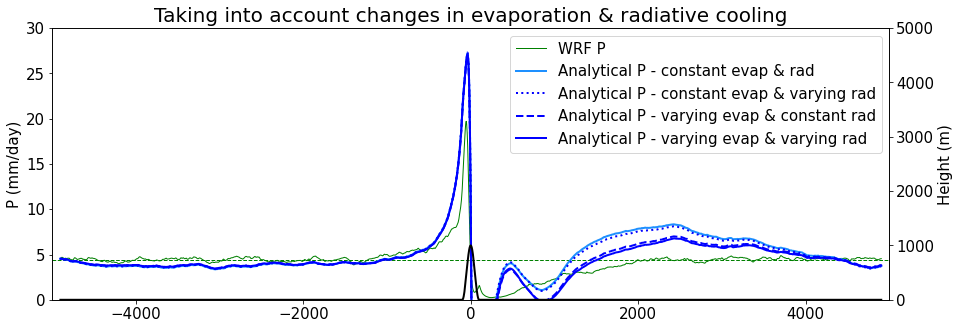

In [76]:
axpr = plot_pr(lw=1)

pr_analytical=precip_analytical_T(x,Lq,tauT,qhat0/tauq,cp*np.array(tmean_p_hat_prime)[::-1])
axpr.plot(hrdist,pr_analytical[::-1],label=r"Analytical P - constant evap & rad",color='dodgerblue',linewidth=2)

pr_analytical=precip_analytical_T(x,Lq,tauT,qhat0/tauq,cp*np.array(tmean_p_hat_prime)[::-1],hralpha_evap1_rad)
axpr.plot(hrdist,pr_analytical[::-1],label=r"Analytical P - constant evap & varying rad",color='b',linestyle=':',linewidth=2)

pr_analytical=precip_analytical_T(x,Lq,tauT,qhat0/tauq,cp*np.array(tmean_p_hat_prime)[::-1],hralpha_evap_rad1)
axpr.plot(hrdist,pr_analytical[::-1],label=r"Analytical P - varying evap & constant rad",color='b',linestyle='--',linewidth=2)

pr_analytical=precip_analytical_T(x,Lq,tauT,qhat0/tauq,cp*np.array(tmean_p_hat_prime)[::-1],hralpha_evap_rad)
axpr.plot(hrdist,pr_analytical[::-1],label=r"Analytical P - varying evap & varying rad",color='b',linewidth=2)

axpr.legend()
axpr.set_title(r"Taking into account changes in evaporation & radiative cooling",fontsize=20)

Text(0.5, 1.0, 'Best fit')

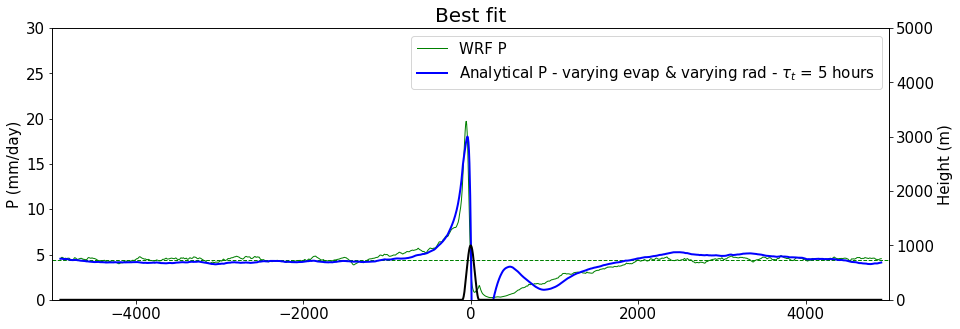

In [78]:
axpr = plot_pr(lw=1)

pr_analytical=precip_analytical_T(x,Lq,5*3600,qhat0/tauq,cp*np.array(tmean_p_hat_prime_bottomt)[::-1],hralpha_evap_rad)
axpr.plot(hrdist,pr_analytical[::-1],label=r"Analytical P - varying evap & varying rad - $\tau_t$ = 5 hours ",color='b',linewidth=2)

axpr.legend()
axpr.set_title(r"Best fit",fontsize=20)

Text(0.5, 1.0, 'Best fit')

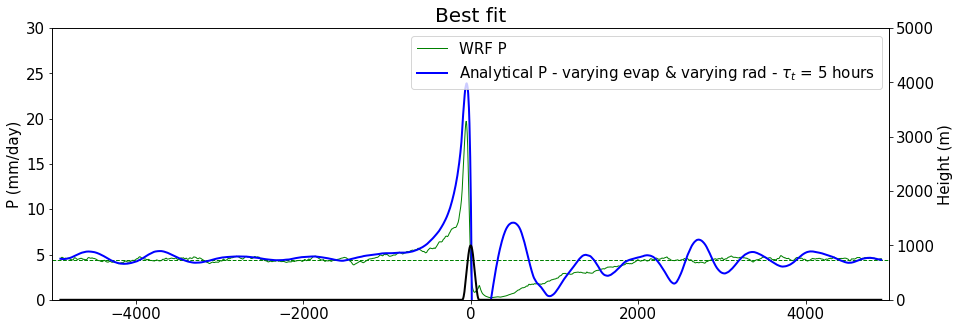

In [165]:
axpr = plot_pr(lw=1)

pr_analytical=precip_analytical_T(x,Lq,5*3600,qhat0/tauq,cp*np.array(drytmean_p_hat_prime)[::-1],0.)
axpr.plot(hrdist,pr_analytical[::-1],label=r"Analytical P - varying evap & varying rad - $\tau_t$ = 5 hours ",color='b',linewidth=2)

axpr.legend()
axpr.set_title(r"Best fit",fontsize=20)

In [48]:
%time hrcape=hrchannel_capecin[0].isel(Time=slice(200,801)).mean(['Time','south_north']).load()

CPU times: user 920 ms, sys: 1.36 s, total: 2.28 s
Wall time: 10.9 s


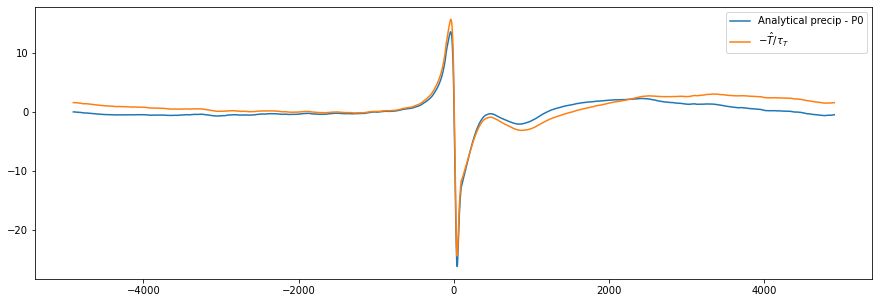

In [36]:
plt.figure(figsize=(15,5))

Lq2=Lq
pr_analytical=precip_analytical_T(x,Lq2,5*3600,qhat0/tauq,cp*np.array(tmean_p_hat_prime)[::-1])

plt.plot(hrdist,(pr_analytical[::-1]-qhat0/tauq*86400*8000/2.26e6),label="Analytical precip - P0")
plt.plot(hrdist,-1/(5*3600)*cp*np.array(tmean_p_hat_prime)*86400*8000/2.26e6,label=r"$-\hat T / \tau_T$")
plt.legend()


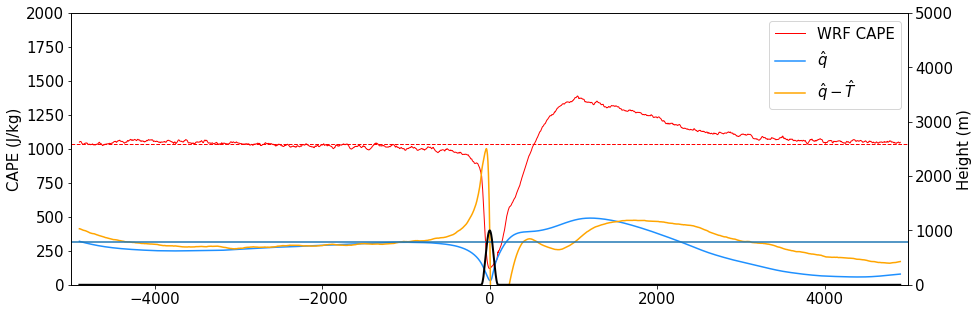

In [54]:
def plot_cape(lw=2,capelim=2000):
    matplotlib.rcParams.update({'font.size': 15})
    _,axpr=plt.subplots(1,1,figsize=(15,5))
    axca=axpr.twinx()
    
    axca.plot(hrdist,hrhgt,color='k',label='Surface elevation',linewidth=2)
    axpr.plot(hrdist,hrcape,label="WRF CAPE",color='r',linewidth=lw)
    axpr.axhline(hrcape[2000:3000].mean(),color='r',linestyle='--',linewidth=1)

    axca.set_xlim( -5000,5000)
    axca.set_ylim( 0,5000)
    axca.set_ylabel("Height (m)")
    
    axpr.set_ylim(0,capelim)
    axpr.set_ylabel('CAPE (J/kg)')
    return axpr
def qhat_analytical_T(x,Lq,LT,qhat0,That):
    f = cumtrapz(np.exp(x/Lq)*That/LT,x,initial=0)
    return qhat0+np.exp(-x/Lq)*f
qhat = qhat_analytical_T(x,Lq,LT,qhat0,cp*np.array(tmean_p_hat_prime)[::-1])

axca=plot_cape(lw=1)
axca.plot(hrdist, qhat[::-1],label=r"$\hat q$",color='dodgerblue')
axca.plot(hrdist, qhat[::-1]-cp*np.array(tmean_p_hat_prime),label=r"$\hat q - \hat T$",color='orange')
#axca.plot(hrdist, -cp*np.array(tmean_p_hat_prime),label=r"$- \hat T$",color='g')
axca.axhline(cape[2000])
axca.legend()

# Taking $\hat q_d(x)$ into account

In [37]:
dq0dp = qmean_p[:,2000:3000].mean('distance_from_mtn').differentiate('pressure')/100
dqdrydx = (-1/10*dryomegamean_p * dq0dp)
qdry = xr.apply_ufunc(cumtrapz,dqdrydx[:,::-1],1000*dqdrydx[:,::-1].distance_from_mtn,input_core_dims=[['distance_from_mtn'],['distance_from_mtn']],kwargs={'initial':0},output_core_dims=[['distance_from_mtn']])
qdryhat = -2.26e6*qdry[4:].integrate('pressure')/(875-125)

In [38]:
dryqmean_p_hat = -dryqmean_p[4:].integrate('pressure')/(875-125)
dryqmean_p_hat_prime=dryqmean_p_hat-dryqmean_p_hat[3000]

Text(0.5, 1.0, '')

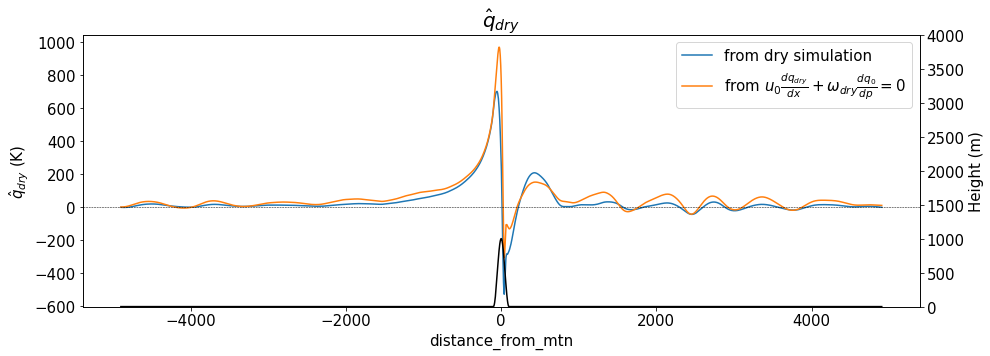

In [43]:
matplotlib.rcParams.update({'font.size': 15})
_,ax=plt.subplots(1,1,figsize=(15,5))

(2.26e6*dryqmean_p_hat_prime).plot(ax=ax,label='from dry simulation')
qdryhat.plot(ax=ax,label=r'from $u_0 \frac{dq_{dry}}{dx} + \omega_{dry} \frac{dq_0}{dp} = 0$')

ax.axhline(0.,color='k',linestyle='--',linewidth=0.5)
ax.legend()
ax.set_ylabel(r'$\hat q_{dry}$ (K)')
ax.set_title(r"$\hat q_{dry}$",fontsize=20)

ax2=ax.twinx()
change_coords_sfc(hrhgt).plot(ax=ax2,color='k',label='Surface elevation')
ax2.set_ylim( 0,4000)
ax2.set_ylabel("Height (m)")
ax2.set_title("")

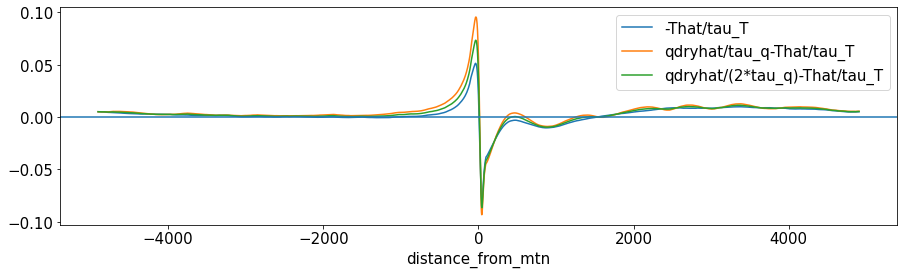

In [81]:
plt.figure(figsize=(15,4))
(-cp*tmean_p_hat_prime_bottomt/(5*3600)).plot(label='-That/tau_T')
(qdryhat/tauq-cp*tmean_p_hat_prime_bottomt/(5*3600)).plot(label='qdryhat/tau_q-That/tau_T')
(qdryhat/2/tauq-cp*tmean_p_hat_prime_bottomt/(5*3600)).plot(label='qdryhat/(2*tau_q)-That/tau_T')
plt.legend()
plt.axhline(0)

# With the 500m mountain

In [47]:
lmchannel= extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/')
lmchannel_p= extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/')
lmchannelprecip=xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.precip.days0-200.nc')

lmtmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.T_PL.days50-200.nc')
lmtmean   = lmtmean.where(lmtmean >100.)  
lmtmean_p = change_coords_pl(lmchannel_p,lmtmean)

lmpr=lmchannelprecip.isel(Time=slice(200,1201)).mean(['Time','south_north']).load()

In [48]:
lmhgt = lmchannel.HGT.isel(south_north=0,Time=-1).persist()

In [54]:
lmtmean_p_hat_prime = hatprime(lmtmean_p,4,11)

In [51]:
def plot_lmpr(lw=2):
    matplotlib.rcParams.update({'font.size': 15})
    _,axpr=plt.subplots(1,1,figsize=(15,5))
    axca=axpr.twinx()
    
    axca.plot(hrdist,lmhgt,color='k',label='Surface elevation',linewidth=2)
    axpr.plot(hrdist,lmpr,label="WRF P",color='g',linewidth=lw)
    axpr.axhline(hrpr[2000:3000].mean(),color='g',linestyle='--',linewidth=1)

    axca.set_xlim( -5000,5000)
    axca.set_ylim( 0,5000)
    axca.set_ylabel("Height (m)")
    
    axpr.set_ylim(0,30)
    axpr.set_ylabel('P (mm/day)')
    return axpr

In [56]:
%%time
lmradc = rad_cooling(lmchannel.isel(Time=slice(200,800))).mean(['south_north']).load()
lmevap = lmchannel.QFX.isel(Time=slice(200,800)).mean(['south_north','Time']).load()

CPU times: user 1.33 s, sys: 9.55 s, total: 10.9 s
Wall time: 25.5 s


In [57]:
%%time
Ms = 4200
Mh = 1500
Mq = Ms-Mh

lmevap_prime = lmevap/lmevap[2000:3000].mean() - 1
lmradc_prime = lmradc/lmradc[2000:3000].mean() - 1

lmalpha_evap_rad1 = np.array((Ms*lmevap_prime)/Mh)[::-1]
lmalpha_evap1_rad = np.array((-Mq*lmradc_prime)/Mh)[::-1]

lmalpha_evap_rad = np.array((Ms*lmevap_prime-Mq*lmradc_prime)/Mh)[::-1]

CPU times: user 6.53 ms, sys: 0 ns, total: 6.53 ms
Wall time: 5.2 ms


Text(0.5, 1.0, 'Taking into account changes in evaporation & radiative cooling')

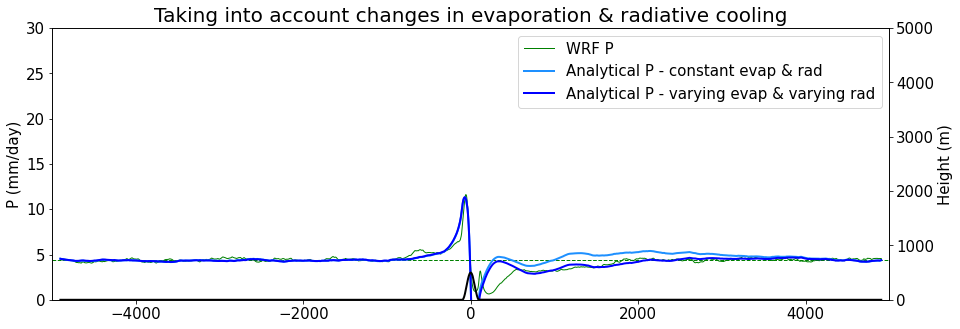

In [82]:
axpr = plot_lmpr(lw=1)

pr_analytical=precip_analytical_T(x,Lq,5*3600,qhat0/tauq,cp*np.array(lmtmean_p_hat_prime)[::-1])
axpr.plot(hrdist,pr_analytical[::-1],label=r"Analytical P - constant evap & rad",color='dodgerblue',linewidth=2)

pr_analytical=precip_analytical_T(x,Lq,5*3600,qhat0/tauq,cp*np.array(lmtmean_p_hat_prime)[::-1],lmalpha_evap_rad)
axpr.plot(hrdist,pr_analytical[::-1],label=r"Analytical P - varying evap & varying rad",color='b',linewidth=2)

axpr.legend()
axpr.set_title(r"Taking into account changes in evaporation & radiative cooling",fontsize=20)

# $\hat T$ with the theory

The linearized thermodynamic equation for the dry mode reads $\mathbf{u}_0\cdot\nabla T_d + \omega_d\dfrac{\partial s_0}{\partial p} = 0$, hence $$T_d(x,p) = \displaystyle\int_{-\infty}^x -\omega_d(x',p)\dfrac{\partial s_0}{\partial p}(p)\mathrm{d}x'/u_0$$

In [19]:
drydeltatmean_p=drytmean_p-drytmean_p[:,2200:2300].mean('distance_from_mtn')

In [20]:
cp=1004.;g=9.81
z0 = g*dryzmean_p[:,2200:2300].mean('distance_from_mtn') 
T0 = (cp*drytmean_p)[:,2200:2300].mean('distance_from_mtn') 
ds0dp = (z0.differentiate('pressure')+T0.differentiate('pressure'))/100

In [21]:
(T0.assign_coords({'z':z0/g}).differentiate('z')+9.81)[4:11].mean()

<xarray.DataArray ()>
array(4.65481845)

In [22]:
int_wdx = np.cumsum(dryomegamean_p[:,::-1],axis=1)[:,::-1]*3000 #(m^2/s)
int_wdx=int_wdx-int_wdx.sel(distance_from_mtn=-2001)
U=10 #m/s
drydeltatmean_p_theory = -int_wdx*ds0dp/U/cp

In [23]:
dsdp = (cp*drytmean_p+g*dryzmean_p).differentiate('pressure')/100
int_wdsdp_dx = np.cumsum((dryomegamean_p*dsdp)[:,::-1],axis=1)[:,::-1]*3000 #(m^2/s)
int_wdsdp_dx=int_wdsdp_dx-int_wdsdp_dx.sel(distance_from_mtn=-2001)
drydeltatmean_p_theory2 = -int_wdsdp_dx/U/cp

In [24]:
int_wu_dx = np.cumsum((dryomegamean_p/dryumean_p)[:,::-1],axis=1)[:,::-1]*3000 #(m^2/s)
int_wu_dx=int_wu_dx-int_wu_dx.sel(distance_from_mtn=-2001)
drydeltatmean_p_theory3 = int_wu_dx*ds0dp/cp

In [25]:
int_wdsdpu_dx = np.cumsum((dryomegamean_p*dsdp/dryumean_p)[:,::-1],axis=1)[:,::-1]*3000 #(m^2/s)
int_wdsdpu_dx=int_wdsdpu_dx-int_wdsdpu_dx.sel(distance_from_mtn=-2001)
drydeltatmean_p_theory4 = int_wdsdpu_dx/cp

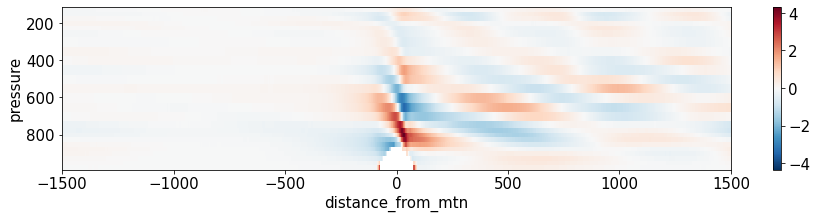

In [122]:
fig,ax=plt.subplots(1,1,figsize=(15,3))
(dsdz-ds0dz)[4:].sel(distance_from_mtn=slice(1500,-1500)).plot(ax=ax,y='pressure',yincrease=False)


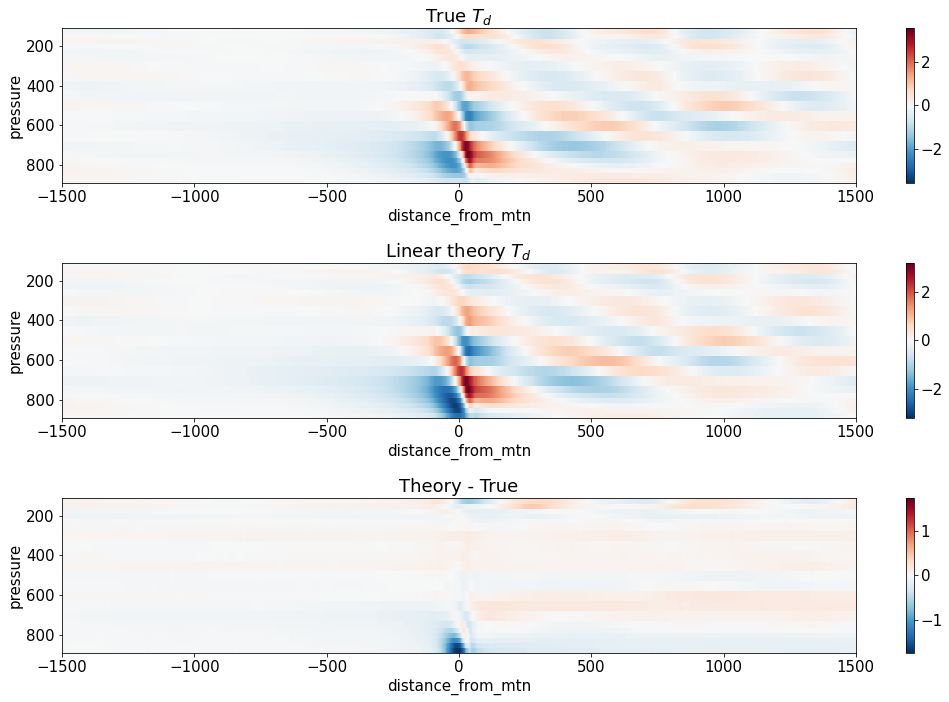

In [148]:
fig,ax=plt.subplots(3,1,figsize=(15,10))
drydeltatmean_p[4:].sel(distance_from_mtn=slice(1500,-1500)).plot(ax=ax[0],yincrease=False);ax[0].set_title(r"True $T_d$")
drydeltatmean_p_theory[4:].sel(distance_from_mtn=slice(1500,-1500)).plot(ax=ax[1],yincrease=False);ax[1].set_title(r"Linear theory $T_d$")
(drydeltatmean_p_theory-drydeltatmean_p)[4:].sel(distance_from_mtn=slice(1500,-1500)).plot(ax=ax[2],yincrease=False);ax[2].set_title(r"Theory - True")
fig.tight_layout()

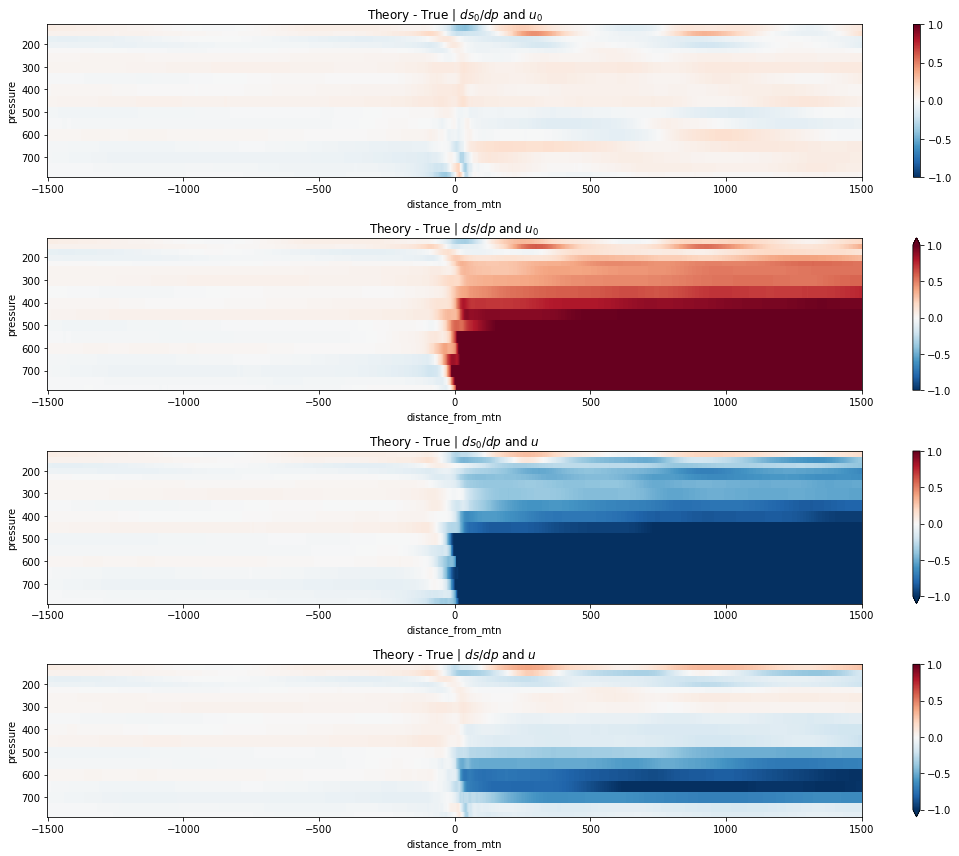

In [26]:
fig,ax=plt.subplots(4,1,figsize=(15,12))
(drydeltatmean_p_theory -drydeltatmean_p)[4:].sel(distance_from_mtn=slice(1500,-1500)).plot(ax=ax[0],yincrease=False,vmin=-1,vmax=1,cmap=plt.cm.RdBu_r);ax[0].set_title(r"Theory - True | $ds_0/dp$ and $u_0$")
(drydeltatmean_p_theory2-drydeltatmean_p)[4:].sel(distance_from_mtn=slice(1500,-1500)).plot(ax=ax[1],yincrease=False,vmin=-1,vmax=1,cmap=plt.cm.RdBu_r);ax[1].set_title(r"Theory - True | $ds/dp$ and $u_0$")
(drydeltatmean_p_theory3-drydeltatmean_p)[4:].sel(distance_from_mtn=slice(1500,-1500)).plot(ax=ax[2],yincrease=False,vmin=-1,vmax=1,cmap=plt.cm.RdBu_r);ax[2].set_title(r"Theory - True | $ds_0/dp$ and $u$")
(drydeltatmean_p_theory4-drydeltatmean_p)[4:].sel(distance_from_mtn=slice(1500,-1500)).plot(ax=ax[3],yincrease=False,vmin=-1,vmax=1,cmap=plt.cm.RdBu_r);ax[3].set_title(r"Theory - True | $ds/dp$ and $u$")

fig.tight_layout()

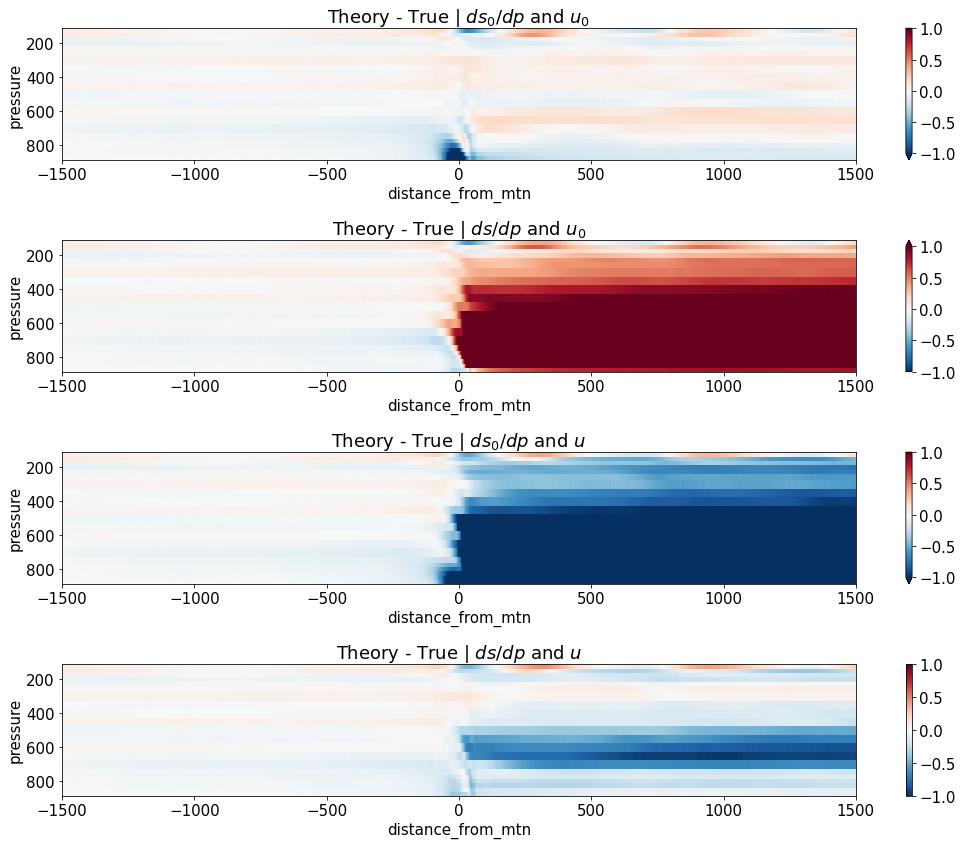

In [153]:
fig,ax=plt.subplots(4,1,figsize=(15,12))
(drydeltatmean_p_theory -drydeltatmean_p)[4:].sel(distance_from_mtn=slice(1500,-1500)).plot(ax=ax[0],yincrease=False,vmin=-1,vmax=1,cmap=plt.cm.RdBu_r);ax[0].set_title(r"Theory - True | $ds_0/dp$ and $u_0$")
(drydeltatmean_p_theory2-drydeltatmean_p)[4:].sel(distance_from_mtn=slice(1500,-1500)).plot(ax=ax[1],yincrease=False,vmin=-1,vmax=1,cmap=plt.cm.RdBu_r);ax[1].set_title(r"Theory - True | $ds/dp$ and $u_0$")
(drydeltatmean_p_theory3-drydeltatmean_p)[4:].sel(distance_from_mtn=slice(1500,-1500)).plot(ax=ax[2],yincrease=False,vmin=-1,vmax=1,cmap=plt.cm.RdBu_r);ax[2].set_title(r"Theory - True | $ds_0/dp$ and $u$")
(drydeltatmean_p_theory4-drydeltatmean_p)[4:].sel(distance_from_mtn=slice(1500,-1500)).plot(ax=ax[3],yincrease=False,vmin=-1,vmax=1,cmap=plt.cm.RdBu_r);ax[3].set_title(r"Theory - True | $ds/dp$ and $u$")

fig.tight_layout()

In [161]:
deltatmean_p=tmean_p-tmean_p[:,2200:2300].mean('distance_from_mtn')

z0 = g*zmean_p[:,2200:2300].mean('distance_from_mtn') 
T0 = (cp*tmean_p)[:,2200:2300].mean('distance_from_mtn') 
ds0dp = (z0.differentiate('pressure')+T0.differentiate('pressure'))/100

int_wdx = np.cumsum(omegamean_p[:,::-1],axis=1)[:,::-1]*3000 #(m^2/s)
int_wdx=int_wdx-int_wdx.sel(distance_from_mtn=-2001)
U=10 #m/s
deltatmean_p_theory = -int_wdx*ds0dp/U/cp

dsdp = (cp*tmean_p+g*zmean_p).differentiate('pressure')/100

int_wdsdpu_dx = np.cumsum((omegamean_p*dsdp/umean_p)[:,::-1],axis=1)[:,::-1]*3000 #(m^2/s)
int_wdsdpu_dx=int_wdsdpu_dx-int_wdsdpu_dx.sel(distance_from_mtn=-2001)
deltatmean_p_theory4 = int_wdsdpu_dx/cp

Text(0.5, 1.0, '')

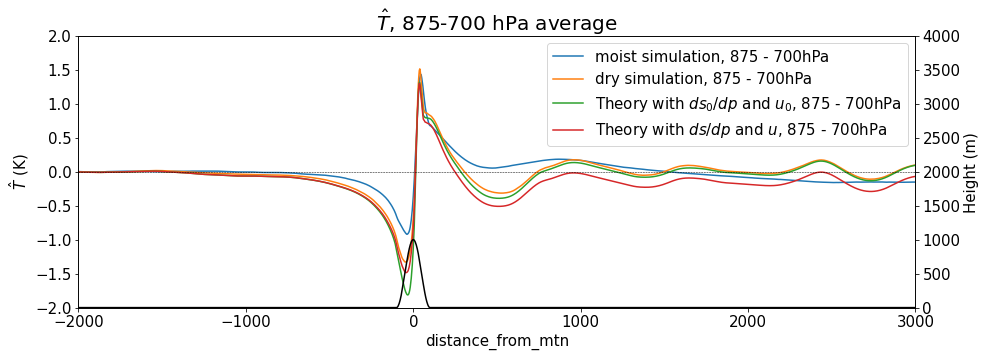

In [163]:
matplotlib.rcParams.update({'font.size': 15})
_,ax=plt.subplots(1,1,figsize=(15,5))

tmean_p_hat_prime.plot(ax=ax,label='moist simulation, 875 - 700hPa')
drytmean_p_hat_prime.plot(ax=ax,label='dry simulation, 875 - 700hPa')
hatprime(drydeltatmean_p_theory,4,11).plot(ax=ax,label=r'Theory with $ds_0/dp$ and $u_0$, 875 - 700hPa')
hatprime(drydeltatmean_p_theory4,4,11).plot(ax=ax,label=r'Theory with $ds/dp$ and $u$, 875 - 700hPa')

ax.axhline(0.,color='k',linestyle='--',linewidth=0.5)
ax.legend()
ax.set_xlim(-2000,3000)
ax.set_ylim(-2,2)
ax.set_ylabel(r'$\hat T$ (K)')
ax.set_title(r"$\hat T$, 875-700 hPa average",fontsize=20)

ax2=ax.twinx()
change_coords_sfc(hrhgt).plot(ax=ax2,color='k',label='Surface elevation')
ax2.set_ylim( 0,4000)
ax2.set_ylabel("Height (m)")
ax2.set_title("")

# Analytical profiles

## With $w = U dh/dx$

In [19]:
# gaussian hill
from scipy.special import erf
def p_gaussian(u):
    xx = np.arange(-1000e3,3000e3)
    A = 1000
    a = 100e3
    hx = A*np.exp(-xx**2/a**2)
    
    P0 = 4. # mm/day
    Gamma = 2e-3 * 1004. * 86400 * 8000 / 2.5e6  #K/m, converted to mm/day/m
    tauT=5*3600
    tauq=6*3600
    Lq = 5*u*tauq
    
    alpha = a/Lq
    P = P0 + Gamma/tauT * (hx - alpha*A*np.sqrt(np.pi)/2*np.exp(-xx/Lq+alpha**2/4)*(1+erf(xx/a - alpha/2)))
    P = np.maximum(0.,P)
    return xx,hx,P

Text(0, 0.5, 'Height (m)')

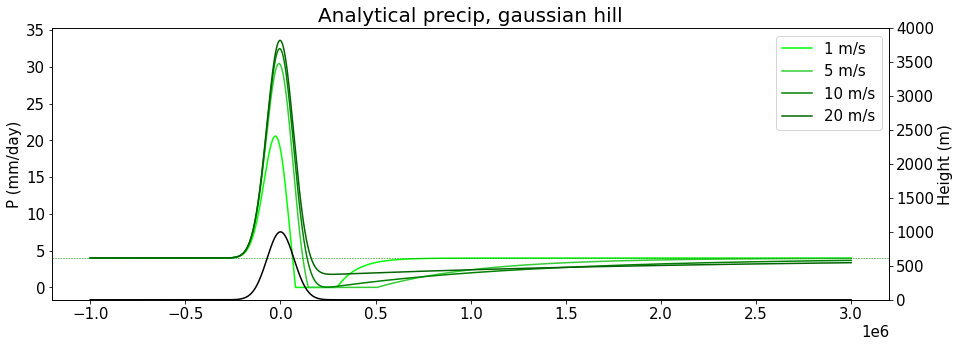

In [189]:
xx,hx,P = p_gaussian(10)
_,_,P5 = p_gaussian(5)
_,_,P1 = p_gaussian(1)
_,_,P20 = p_gaussian(20)

matplotlib.rcParams.update({'font.size': 15})
_,ax=plt.subplots(1,1,figsize=(15,5))

ax.plot(xx,P1,color='lime',label='1 m/s')
ax.plot(xx,P5,color='limegreen',label='5 m/s')
ax.plot(xx,P,color='g',label='10 m/s')
ax.plot(xx,P20,color='darkgreen',label='20 m/s')
ax.axhline(4.,color='g',linestyle='--',linewidth=0.5)
ax.set_ylabel('P (mm/day)')
ax.set_title("Analytical precip, gaussian hill",fontsize=20)
ax.legend()


ax2=ax.twinx()
ax2.plot(xx,hx,color='k')
ax2.set_ylim( 0,4000)
ax2.set_ylabel("Height (m)")

# With linear theory $w$

In [246]:
from scipy.signal import hilbert
from scipy.integrate import cumtrapz
import scipy.linalg as spl
def nonlinear_mountain_wave(h,N,U,x,z):
    z2=np.array(z).transpose()[::-1]
    f_L = -np.imag(hilbert(h))
    l=N/U
    H = h+1.j*f_L
    niter=20
    for i in range(niter):
        H = -1j*np.exp(-1j*l*h)*(np.imag(hilbert(np.real(H*np.exp(1j*l*h))))+1j*np.imag(hilbert(np.imag(H*np.exp(1j*l*h)))))
    f=np.imag(H)
    delta = h[:,None]*np.cos(l*(z[None,:]-h[:,None]))+f[:,None]*np.sin(l*(z[None,:]-h[:,None]))
    w=U*np.gradient(delta,x,axis=0)
    return xr.DataArray(z[None,:]-delta,coords={'x':x,'z':z},dims={'x':x,'z':z}),xr.DataArray(w,coords={'x':x,'z':z},dims={'x':x,'z':z})

def k_vector(Nx,dx):
    return 2*np.pi*np.fft.fftfreq(Nx,dx)

def m_exponent(k,N,U):
    return - np.sign(k**2-N**2/U**2)**((np.sign(k+1e-4*k[1])+1)/2) * np.sqrt(k**2-N**2/U**2+0.j) #1e-4*k[1] it there to avoid fractional powers

def linear_mountain_wave(h,N,U,x,z):
    k=k_vector(len(x),x[1]-x[0])
    h_hat = np.fft.fft(h)
    w_hat = 1j*k[:,None]*U*h_hat[:,None]*np.exp( m_exponent(k[:,None],N,U)  *  z[None,:]) 
    w=xr.DataArray(np.real(np.fft.ifft(w_hat,axis=0)),coords={'x':x,'z':z},dims={'x':x,'z':z})
    return w

from orographicPrecipitation.smith_lm import HwCw
from orographicPrecipitation.precip_extremes_scaling import moist_adiabatic_lapse_rate

def smith_theory(u,tau=2000,kind='gaussian'):
    ts=np.array([300.])
    ps=np.array([100000.])
    gamma_m = moist_adiabatic_lapse_rate(ts,ps,'era')
    gamma = 0.9*gamma_m
    Hw,Cw = HwCw(ts,ps,gamma)
    N=np.sqrt(9.81/ts*(gamma_m-gamma))

    tau_c=tau
    tau_f=tau
    P0=4.5 #mm/day
    
    xx=np.arange(-10000e3,10000e3,10e3)
    A = 1000
    a = 100e3
    if kind=='gaussian':
        hx = A*np.exp(-xx**2/2/(a/2)**2)
    elif kind=='cos':
        hx = A/2*(1+np.cos(np.pi*np.maximum(-1,np.minimum(1,xx/a))))
    k=k_vector(len(xx),xx[1]-xx[0])
    
    P=P0+86400*np.real(np.fft.ifft(Cw*np.fft.fft(hx)*1j*u*k/(1-Hw*m_exponent(k,N,u))/(1+1j*u*k*tau_c)/(1+1j*u*k*tau_f)))
    return xx,hx,P

def linear_p_theory(u,kind='gaussian',A=1000):
    xx=np.arange(-10000e3,10000e3,10e3)
    a = 100e3
    if kind=='gaussian':
        hx = A*np.exp(-xx**2/2/(a/2)**2)
    elif kind=='cos':
        hx = A/2*(1+np.cos(np.pi*np.maximum(-1,np.minimum(1,xx/a))))
    elif kind=='agnesi':
        a/=2
        hx = A*a**2/(xx**2+a**2)
    z=np.arange(0,10000,100)
    k=k_vector(len(xx),xx[1]-xx[0])
    
    P0 = 4. # mm/day
    
    Gamma_kpm = 2e-3 # K/m
    N=np.sqrt(9.81/300 * Gamma_kpm)
    Gamma = Gamma_kpm * 1004. * 86400 * 8000 / 2.5e6  # converted to mm/day/m
    
    tauT=5*3600
    tauq=6*3600
    Lq = 5*u*tauq
    
    z_slice = z[np.where((z>=500) & (z<=2500))]
    Pprimehat = 1j*k/(tauT*(1j*k + 1/Lq)) * Gamma * np.fft.fft(hx) * np.exp( m_exponent(k[:,None],N,u)  *  z_slice[None,:]).mean(axis=1) 
    
    P = P0 + np.real(np.fft.ifft(Pprimehat))
    P = np.maximum(0.,P)
    return xx,hx,P

def nonlinear_p_theory(u,kind='gaussian'):
    xx=np.arange(-20000e3,20000e3,10e3)
    A = 1000
    a = 100e3
    if kind=='gaussian':
        hx = A*np.exp(-xx**2/2/(a/2)**2)
    elif kind=='cos':
        hx = A/2*(1+np.cos(np.pi*np.maximum(-1,np.minimum(1,xx/a))))
    z=np.arange(0,10000,100)
    k=k_vector(len(xx),xx[1]-xx[0])
    
    P0 = 4. # mm/day
    
    Gamma_kpm = 2e-3 # K/m
    N=np.sqrt(9.81/300 * Gamma_kpm)
    Gamma = Gamma_kpm * 1004. * 86400 * 8000 / 2.5e6  # converted to mm/day/m
    
    tauT=5*3600
    tauq=6*3600
    Lq = 5*u*tauq
        
    _,w=nonlinear_mountain_wave(hx,N,u,xx,z)
    hx_xr = xr.DataArray(hx,coords={'x':w.x},dims=['x'])
    what = w.where((w.z>hx_xr+500) & (w.z<hx_xr+2500)).mean('z')

    Pprimehat = -1j*k/(tauT*(1j*k + 1/Lq)) * Gamma * 1j/(u*(k+1e-10)) *np.fft.fft(what)
    
    P = P0 + np.real(np.fft.ifft(Pprimehat))
    P = np.maximum(0.,P)
    return xx,hx,P

In [175]:
def linear_p_theory_2(u,kind='gaussian'):
    """In the limit where Lq very big compared to mtn half width"""
    xx=np.arange(-10000e3,10000e3,10e3)
    A = 1000
    a = 100e3
    if kind=='gaussian':
        hx = A*np.exp(-xx**2/2/(a/2)**2)
    elif kind=='cos':
        hx = A/2*(1+np.cos(np.pi*np.maximum(-1,np.minimum(1,xx/a))))
    z=np.arange(0,10000,100)
    k=k_vector(len(xx),xx[1]-xx[0])
    
    P0 = 4. # mm/day
    
    Gamma_kpm = 2e-3 # K/m
    N=np.sqrt(9.81/300 * Gamma_kpm)
    Gamma = Gamma_kpm * 1004. * 86400 * 8000 / 2.5e6  # converted to mm/day/m
    
    tauT=5*3600
    tauq=6*3600
    Lq = 5*u*tauq
    
    z_slice = z[np.where((z>=500) & (z<=2500))]
    Pprimehat = 1/tauT * Gamma * np.fft.fft(hx) * np.exp( m_exponent(k[:,None],N,u)  *  z_slice[None,:]).mean(axis=1) 
    
    P = P0 + np.real(np.fft.ifft(Pprimehat))
    P = np.maximum(0.,P)
    return xx,hx,P

Text(0, 0.5, 'Height (m)')

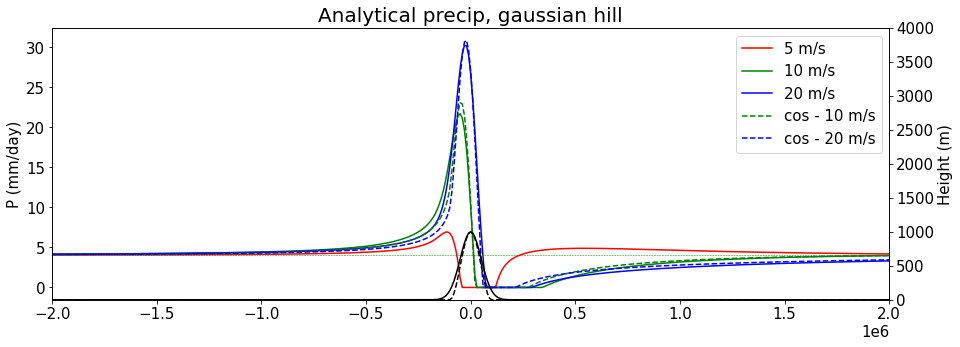

In [104]:
xx,hx,P = linear_p_theory(10)
_,_,P20 = linear_p_theory(20)
xx,hx,P5 = linear_p_theory(5)

xx,hx2,P10_2 = linear_p_theory(10,'cos')
_,_,P20_2 = linear_p_theory(20,'cos')

matplotlib.rcParams.update({'font.size': 15})
_,ax=plt.subplots(1,1,figsize=(15,5))

ax.plot(xx,P5,color='r',label='5 m/s')
ax.plot(xx,P,color='g',label='10 m/s')
ax.plot(xx,P20,color='b',label='20 m/s')

ax.plot(xx,P10_2,color='g',linestyle='--',label='cos - 10 m/s')
ax.plot(xx,P20_2,color='b',linestyle='--',label='cos - 20 m/s')

ax.axhline(4.,color='g',linestyle='--',linewidth=0.5)
ax.set_ylabel('P (mm/day)')
ax.set_title("Analytical precip, gaussian hill",fontsize=20)
ax.legend()

ax.set_xlim(-2000e3,2000e3)


ax2=ax.twinx()
ax2.plot(xx,hx,color='k')
ax2.plot(xx,hx2,color='k',linestyle='--')
ax2.set_ylim( 0,4000)
ax2.set_ylabel("Height (m)")

Text(0, 0.5, 'Height (m)')

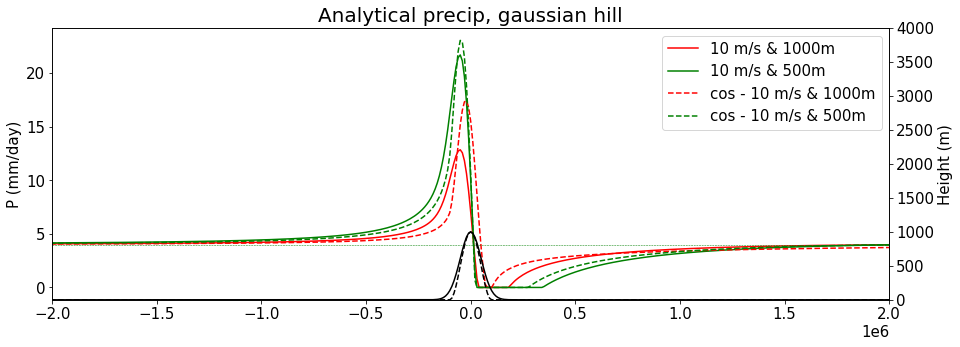

In [239]:
xx,hx,P = linear_p_theory(10)
_,_,P500 = linear_p_theory(10,kind='gaussian',A=500)

xx,hx2,P_2 = linear_p_theory(10,'cos')
_,_,P500_2 = linear_p_theory(20,'cos',500)

matplotlib.rcParams.update({'font.size': 15})
_,ax=plt.subplots(1,1,figsize=(15,5))

ax.plot(xx,P500,color='r',label='10 m/s & 1000m')
ax.plot(xx,   P,color='g',label='10 m/s & 500m')

ax.plot(xx,P500_2,color='r',linestyle='--',label='cos - 10 m/s & 1000m')
ax.plot(xx,   P_2,color='g',linestyle='--',label='cos - 10 m/s & 500m')

ax.axhline(4.,color='g',linestyle='--',linewidth=0.5)
ax.set_ylabel('P (mm/day)')
ax.set_title("Analytical precip, gaussian hill",fontsize=20)
ax.legend()

ax.set_xlim(-2000e3,2000e3)


ax2=ax.twinx()
ax2.plot(xx,hx,color='k')
ax2.plot(xx,hx2,color='k',linestyle='--')
ax2.set_ylim( 0,4000)
ax2.set_ylabel("Height (m)")

Text(0, 0.5, 'Height (m)')

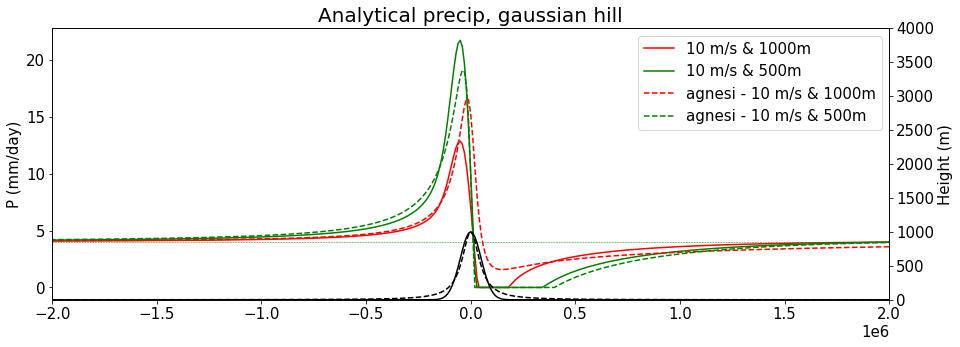

In [247]:
xx,hx,P = linear_p_theory(10)
_,_,P500 = linear_p_theory(10,kind='gaussian',A=500)

xx,hx2,P_2 = linear_p_theory(10,'agnesi')
_,_,P500_2 = linear_p_theory(20,'agnesi',500)

matplotlib.rcParams.update({'font.size': 15})
_,ax=plt.subplots(1,1,figsize=(15,5))

ax.plot(xx,P500,color='r',label='10 m/s & 1000m')
ax.plot(xx,   P,color='g',label='10 m/s & 500m')

ax.plot(xx,P500_2,color='r',linestyle='--',label='agnesi - 10 m/s & 1000m')
ax.plot(xx,   P_2,color='g',linestyle='--',label='agnesi - 10 m/s & 500m')

ax.axhline(4.,color='g',linestyle='--',linewidth=0.5)
ax.set_ylabel('P (mm/day)')
ax.set_title("Analytical precip, gaussian hill",fontsize=20)
ax.legend()

ax.set_xlim(-2000e3,2000e3)


ax2=ax.twinx()
ax2.plot(xx,hx,color='k')
ax2.plot(xx,hx2,color='k',linestyle='--')
ax2.set_ylim( 0,4000)
ax2.set_ylabel("Height (m)")

Text(0, 0.5, 'Height (m)')

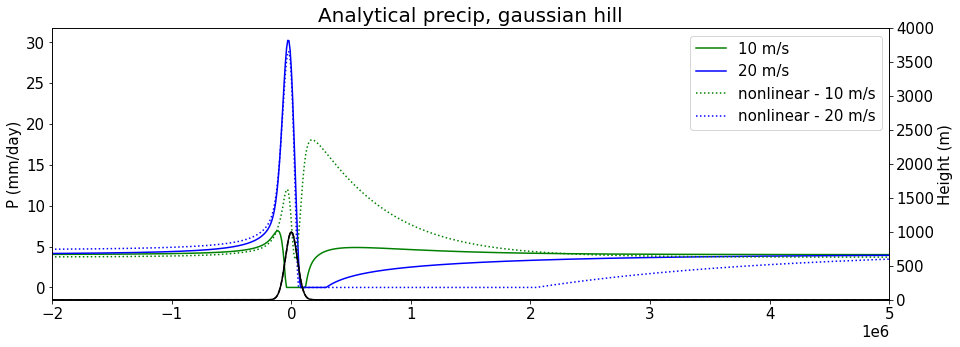

In [178]:
xx,hx,P = linear_p_theory(5)
_,_,P20 = linear_p_theory(20)

xx2,hx2,P10_2 = nonlinear_p_theory(5)
_,_,P20_2 = nonlinear_p_theory(20)

matplotlib.rcParams.update({'font.size': 15})
_,ax=plt.subplots(1,1,figsize=(15,5))

ax.plot(xx,P,color='g',label='10 m/s')
ax.plot(xx,P20,color='b',label='20 m/s')

ax.plot(xx2,P10_2,color='g',linestyle=':',label='nonlinear - 10 m/s')
ax.plot(xx2,P20_2,color='b',linestyle=':',label='nonlinear - 20 m/s')

ax.set_ylabel('P (mm/day)')
ax.set_title("Analytical precip, gaussian hill",fontsize=20)
ax.legend()

ax.set_xlim(-2000e3,5000e3)


ax2=ax.twinx()
ax2.plot(xx,hx,color='k')
ax2.plot(xx2,hx2,color='k',linestyle='--')
ax2.set_ylim( 0,4000)
ax2.set_ylabel("Height (m)")

Text(0, 0.5, 'Height (m)')

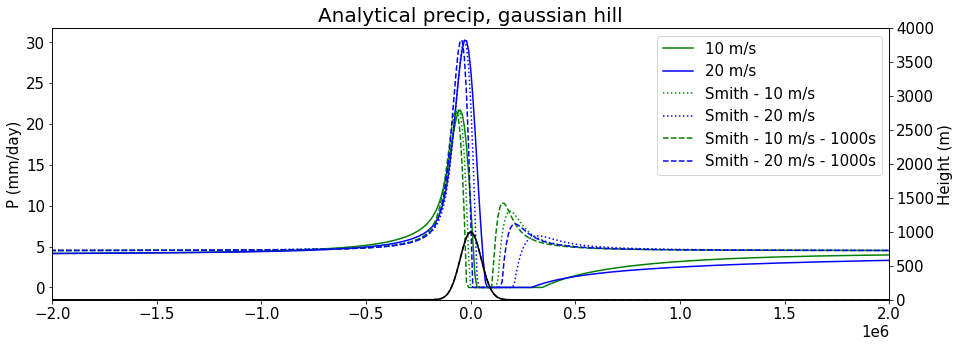

In [237]:
xx,hx,P = linear_p_theory(10)
_,_,P20 = linear_p_theory(20)

xx2,hx2,P10_2 = smith_theory(10)
_,_,P20_2 = smith_theory(20)

_,_,P10_3 = smith_theory(10,1000)
_,_,P20_3 = smith_theory(20,1000)

P10_2=np.maximum(4.5+(P10_2-4.5)*(P-4.5).max()/(P10_2-4.5).max()  ,0.)
P20_2=np.maximum(4.5+(P20_2-4.5)*(P20-4.5).max()/(P20_2-4.5).max(),0.)

P10_3=np.maximum(4.5+(P10_3-4.5)*(P-4.5).max()/(P10_3-4.5).max()  ,0.)
P20_3=np.maximum(4.5+(P20_3-4.5)*(P20-4.5).max()/(P20_3-4.5).max(),0.)

matplotlib.rcParams.update({'font.size': 15})
_,ax=plt.subplots(1,1,figsize=(15,5))

ax.plot(xx,P,color='g',label='10 m/s')
ax.plot(xx,P20,color='b',label='20 m/s')

ax.plot(xx2,P10_2,color='g',linestyle=':',label='Smith - 10 m/s')
ax.plot(xx2,P20_2,color='b',linestyle=':',label='Smith - 20 m/s')

ax.plot(xx2,P10_3,color='g',linestyle='--',label='Smith - 10 m/s - 1000s')
ax.plot(xx2,P20_3,color='b',linestyle='--',label='Smith - 20 m/s - 1000s')

ax.set_ylabel('P (mm/day)')
ax.set_title("Analytical precip, gaussian hill",fontsize=20)
ax.legend()

ax.set_xlim(-2000e3,2000e3)


ax2=ax.twinx()
ax2.plot(xx,hx,color='k')
ax2.plot(xx2,hx2,color='k',linestyle='--')
ax2.set_ylim( 0,4000)
ax2.set_ylabel("Height (m)")

Text(0, 0.5, 'Height (m)')

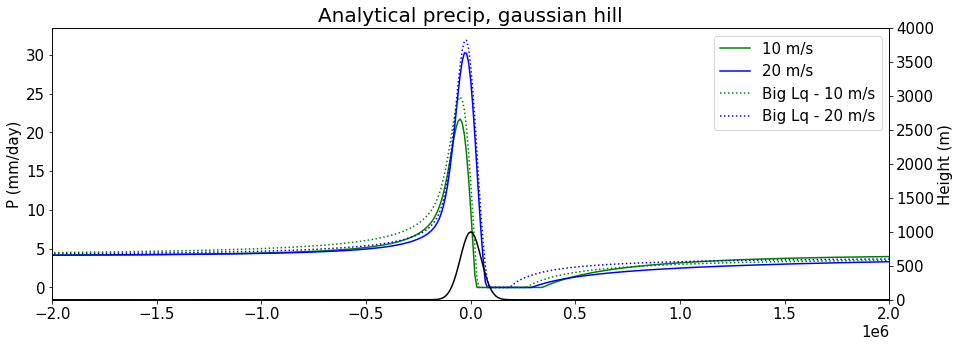

In [177]:
xx,hx,P = linear_p_theory(10)
_,_,P20 = linear_p_theory(20)

xx2,hx2,P_2 = linear_p_theory_2(10)
_,_,P20_2 = linear_p_theory_2(20)

matplotlib.rcParams.update({'font.size': 15})
_,ax=plt.subplots(1,1,figsize=(15,5))

ax.plot(xx,P,color='g',label='10 m/s')
ax.plot(xx,P20,color='b',label='20 m/s')

ax.plot(xx2,P_2,color='g',linestyle=':',label='Big Lq - 10 m/s')
ax.plot(xx2,P20_2,color='b',linestyle=':',label='Big Lq - 20 m/s')

ax.set_ylabel('P (mm/day)')
ax.set_title("Analytical precip, gaussian hill",fontsize=20)
ax.legend()

ax.set_xlim(-2000e3,2000e3)


ax2=ax.twinx()
ax2.plot(xx,hx,color='k')
ax2.set_ylim( 0,4000)
ax2.set_ylabel("Height (m)")

In [107]:
xx = np.arange(-1000e3,3000e3,10e3)
A = 1000
a = 100e3
hx = A*np.exp(-xx**2/a**2)
z=np.arange(0,10000,100)

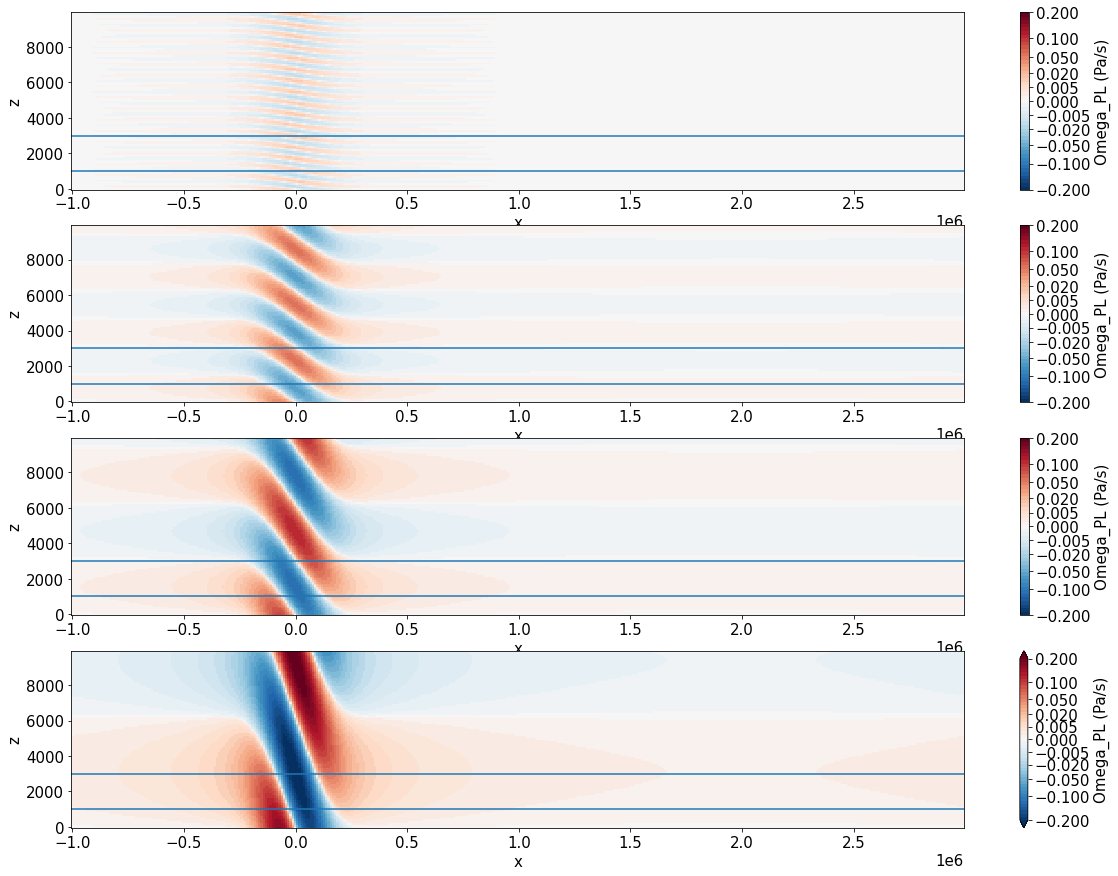

In [87]:
def f(x):
    return np.sign(x)*x**2
fig,axs=plt.subplots(4,1,figsize=(20,15))
wmax=0.2
wlevs=f(np.linspace(-wmax**(1/2),wmax**(1/2),50))
wticks=[-0.2,-0.1,-0.05,-0.02,-0.005,0,0.005,0.02,0.05,0.1,0.2]

w=linear_mountain_wave(hx,1e-2,1,xx,z)
w.plot(ax=axs[0],y='z',levels=wlevs,cbar_kwargs={'ticks':wticks, 'label':'Omega_PL (Pa/s)'})

w=linear_mountain_wave(hx,1e-2,5,xx,z)
w.plot(ax=axs[1],y='z',levels=wlevs,cbar_kwargs={'ticks':wticks, 'label':'Omega_PL (Pa/s)'})

w=linear_mountain_wave(hx,1e-2,10,xx,z)
w.plot(ax=axs[2],y='z',levels=wlevs,cbar_kwargs={'ticks':wticks, 'label':'Omega_PL (Pa/s)'})

w=linear_mountain_wave(hx,1e-2,20,xx,z)
w.plot(ax=axs[3],y='z',levels=wlevs,cbar_kwargs={'ticks':wticks, 'label':'Omega_PL (Pa/s)'})

for ax in axs:
    ax.axhline(1000)
    ax.axhline(3000)

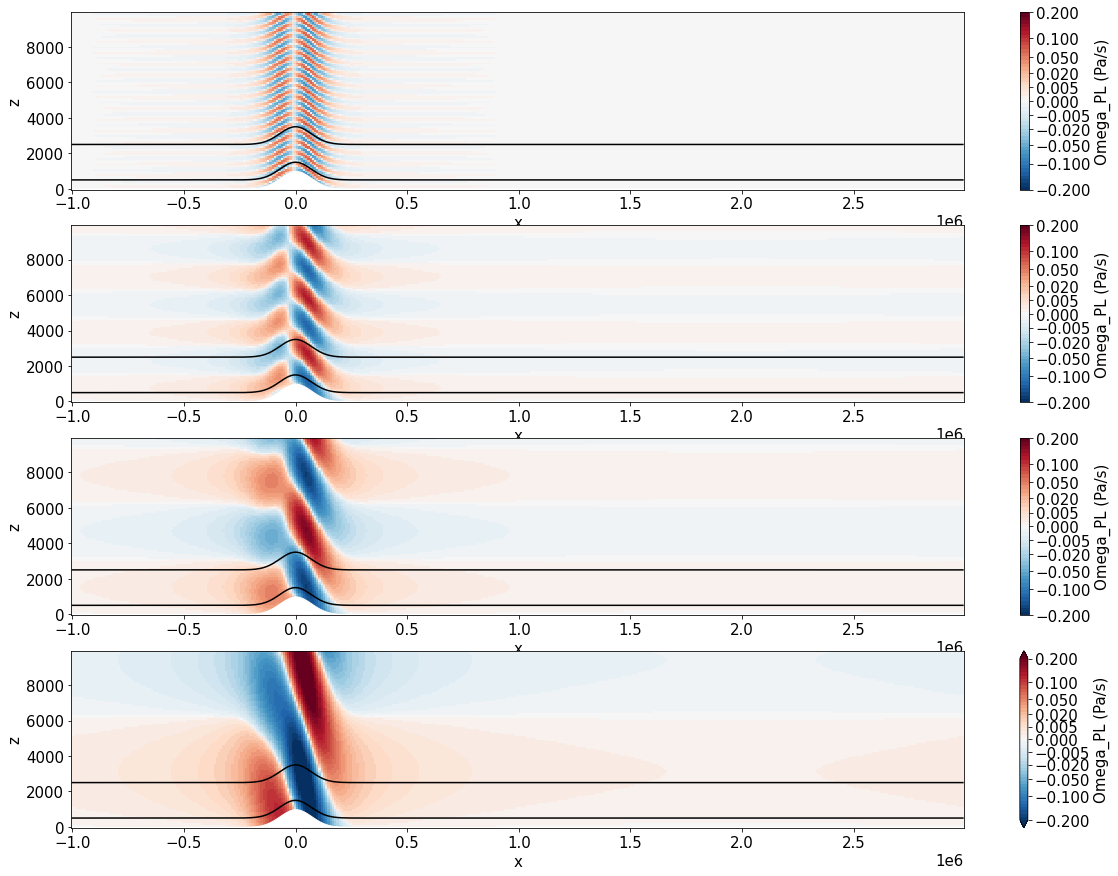

In [111]:
def f(x):
    return np.sign(x)*x**2
fig,axs=plt.subplots(4,1,figsize=(20,15))
wmax=0.2
wlevs=f(np.linspace(-wmax**(1/2),wmax**(1/2),50))
wticks=[-0.2,-0.1,-0.05,-0.02,-0.005,0,0.005,0.02,0.05,0.1,0.2]

_,w=nonlinear_mountain_wave(hx,1e-2,1,xx,z)
w.plot(ax=axs[0],y='z',levels=wlevs,cbar_kwargs={'ticks':wticks, 'label':'Omega_PL (Pa/s)'})

_,w=nonlinear_mountain_wave(hx,1e-2,5,xx,z)
w.plot(ax=axs[1],y='z',levels=wlevs,cbar_kwargs={'ticks':wticks, 'label':'Omega_PL (Pa/s)'})

_,w=nonlinear_mountain_wave(hx,1e-2,10,xx,z)
w.plot(ax=axs[2],y='z',levels=wlevs,cbar_kwargs={'ticks':wticks, 'label':'Omega_PL (Pa/s)'})

_,w=nonlinear_mountain_wave(hx,1e-2,20,xx,z)
w.plot(ax=axs[3],y='z',levels=wlevs,cbar_kwargs={'ticks':wticks, 'label':'Omega_PL (Pa/s)'})

for ax in axs:
    ax.plot(xx,hx+500,color='k')
    ax.plot(xx,hx+2500,color='k')
    ax.fill_between(xx,0*xx**0,hx,color='w')
    #ax.set_xlim

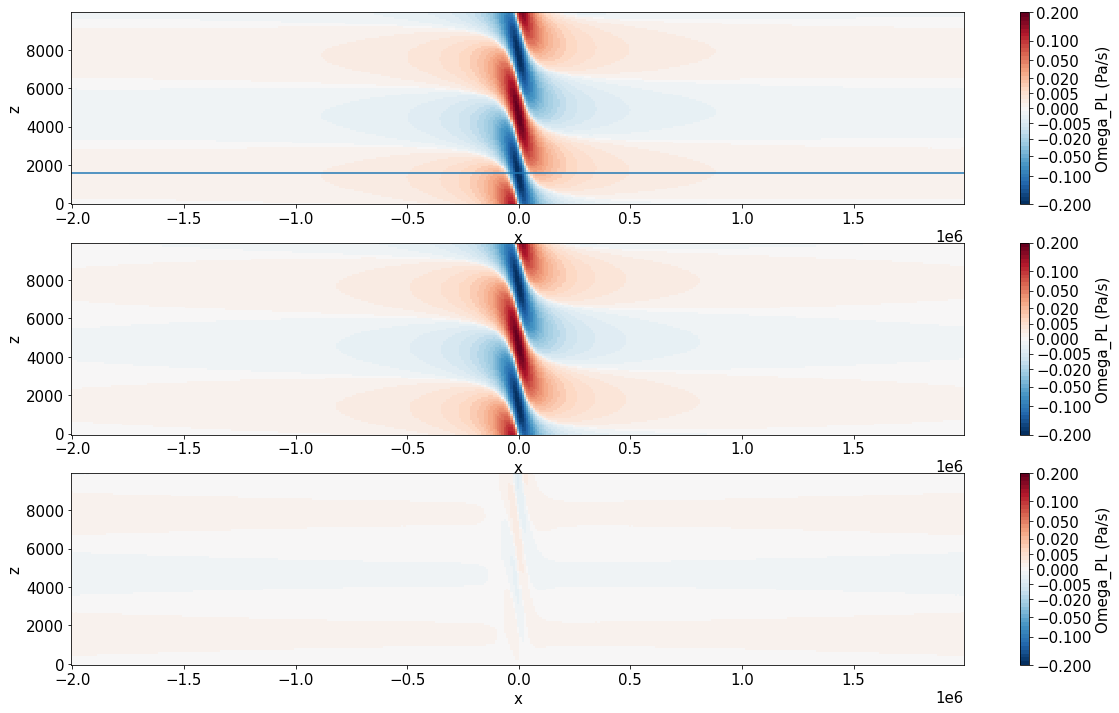

In [262]:
xx = np.arange(-2000e3,2000e3,10e3)
A = 1000
a = 50e3
hx = A*a**2/(xx**2+a**2)

fig,axs=plt.subplots(3,1,figsize=(20,12))
z=np.arange(0,10000,100)
w=linear_mountain_wave(hx,1e-2,10,xx,z)
w.plot(ax=axs[0],y='z',levels=wlevs,cbar_kwargs={'ticks':wticks, 'label':'Omega_PL (Pa/s)'})
axs[0].axhline(np.pi/2*1e3)

l = 1e-3
w_analytical = 10*A*a*((w.x**2-a**2)*np.sin(l*w.z) - 2*w.x*a*np.cos(l*w.z))/(w.x**2+a**2)**2
w_analytical.plot(ax=axs[1],y='z',levels=wlevs,cbar_kwargs={'ticks':wticks, 'label':'Omega_PL (Pa/s)'})

(w-w_analytical).plot(ax=axs[2],y='z',levels=wlevs,cbar_kwargs={'ticks':wticks, 'label':'Omega_PL (Pa/s)'})


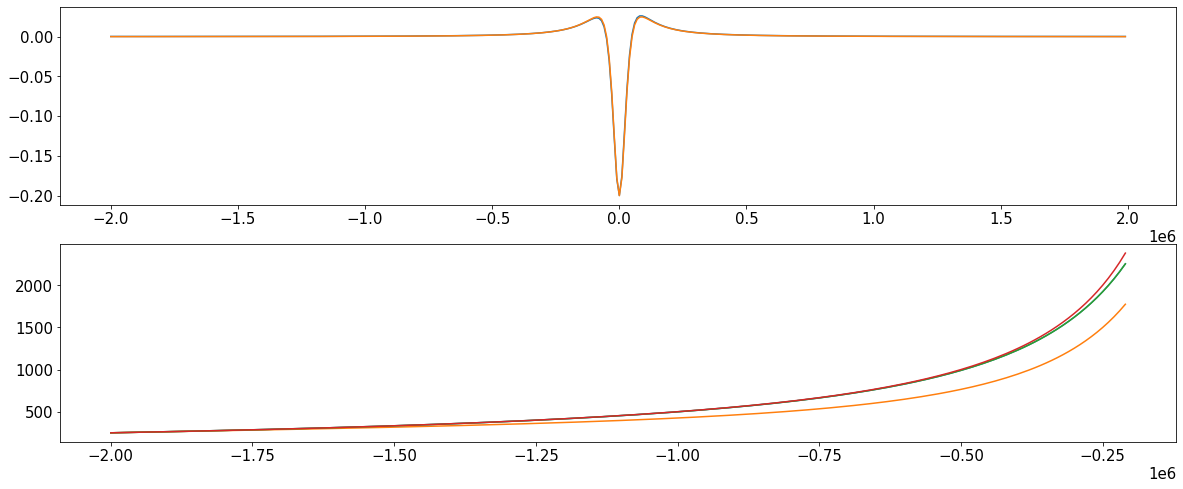

In [274]:
fig,axs=plt.subplots(2,1,figsize=(20,8))
axs[0].plot(w.x,w.sel(z=np.pi/2*1e3,method='nearest'))
axs[0].plot(xx,10*A*a*(xx**2-a**2)/(xx**2+a**2)**2)
x=xx[:180]
w1 = 10*A*a*(x**2-a**2)/(x**2+a**2)**2
Lq=1e6
axs[1].plot(x,cumtrapz(w1,x,initial=0)+a*A*10/2e6)
axs[1].plot(x,np.exp(-x/Lq)*cumtrapz(w1*np.exp(x/Lq),x,initial=0)+a*A*10/2e6)
axs[1].plot(x,a*A*10*(-x)/(x**2+a**2))
axs[1].plot(x,-a*A*10/x)

# Precipitation-buoyancy relationship

In [5]:
hrchannelprecip_hourly = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.precip.hourly.days0-200.nc')

In [246]:
%%time
T = hrchannel_p.T_PL[4600:4800,1:16,:,2200:].load()
q = hrchannel_p.Q_PL[4600:4800,1:16,:,2200:].load()
pr = hrchannelprecip_hourly[4600:4800,:,2200:]

CPU times: user 1.1 s, sys: 20 s, total: 21.1 s
Wall time: 51.1 s


In [247]:
P = test[1:16]

In [248]:
c=6
TL = 1004.*T[:,c:].mean('num_press_levels_stag')
qL = 2.5e6*q[:,c:].mean('num_press_levels_stag')
eb = 1004.*T[:,:c].mean('num_press_levels_stag')+2.5e6*q[:,:c].mean('num_press_levels_stag')

In [249]:
qLstar = 2.5e6*qsat(T[:,c:],P[c:]/100).mean('num_press_levels_stag')

In [250]:
wL=0.48
wb=0.52
piL=0.88
pib=0.97

In [251]:
BL = 9.81/(TL+qLstar) * piL * (wb*eb/pib + (wL*(TL+qL)-(TL+qLstar))/piL)

In [319]:
BL.min()

<xarray.DataArray ()>
array(-0.94822818)

In [320]:
BL.max()

<xarray.DataArray ()>
array(0.05568645)

In [322]:

def bins_slice(a,b,bins=np.arange(-0.94,-0.04,0.01)):
    bin_centers=(bins[1:]+bins[:-1])/2
    digitized = np.digitize(np.array(a), bins)
    bin_means = [np.array(b)[digitized == i].mean() for i in range(1, len(bins))]
    return bin_centers,bin_means
bin_centers_BL,bin_means = bins_slice(BL,pr)


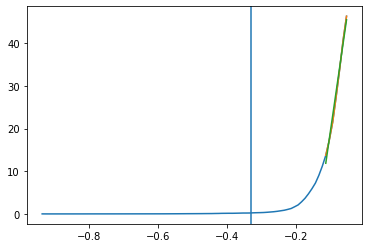

In [325]:
plt.plot(bin_centers_BL,bin_means)
i=82
j=90
plt.plot(bin_centers_BL[i:j],bin_means[i:j])
b=bin_centers_BL[i:j]
m,k= np.polyfit(b,bin_means[i:j],1)
plt.plot(b,m*b+k)
plt.axvline(-0.33)

In [256]:
eLb = np.array((TL+qL).mean())
eLstarb = np.array((TL+qLstar).mean())
qLstarb = np.array(qLstar.mean())
TLb = np.array(TL.mean())
ebb = np.array(eb.mean())

In [257]:
alpha = m/86400 * 2.5e6
dBLdeb = 9.81/eLstarb*piL*wb/pib
dBLdqL = 9.81/eLstarb*wL
dBLdTL = -9.81/eLstarb*piL *((wb/pib*ebb/eLstarb + wL/piL* eLb/eLstarb) * (1+qLstarb/(461*(TLb/1004)**2))-wL/piL)

In [258]:
tauq = 8000/alpha/dBLdqL
tauT = -8000/alpha/dBLdTL

In [259]:
tauq/3600

8.963626700950982

In [260]:
tauT/3600

8.855648812396149

In [350]:
kappa=0.1

In [351]:
TLref = TL.mean() + kappa*TL.std()
qLref = qL.mean() - kappa*qL.std()
ebref = eb.mean() - kappa*eb.std()
qLstarref = 2.5e6*qsat(TLref/1004.,np.array(P[c:].mean())/100)

In [352]:
BLref = 9.81/(TLref+qLstarref) * piL * (wb*ebref/pib + (wL*(TLref+qLref)-(TLref+qLstarref))/piL)
prc=bin_means[np.argmin((bin_centers_BL-np.array(BLref))**2)]

In [353]:
BLref

<xarray.DataArray ()>
array(-0.47054256)

In [354]:
TLprime = TL - TLref
qLprime = qL - qLref
ebprime = eb - ebref

In [355]:
(TLprime*(pr>prc)).mean()/TLprime.mean()

<xarray.DataArray ()>
array(0.29407043)

In [356]:
(qLprime*(pr>prc)).mean()/qLprime.mean()

<xarray.DataArray ()>
array(2.24121042)

In [357]:
TLprime.mean()

<xarray.DataArray 'T_PL' ()>
array(-1642.65873831)

In [291]:
qLref = qL.mean() - 0.5*qL.std()
BLref = 9.81/(TLref+qLstarref) * piL * (wb*ebref/pib + (wL*(TLref+qLref)-(TLref+qLstarref))/piL)
prc=bin_means[np.argmin((bin_centers-np.array(BLref))**2)]
qLprime = qL - qLref
(qLprime*(pr>prc)).mean()/qLprime.mean()

<xarray.DataArray ()>
array(0.52624939)

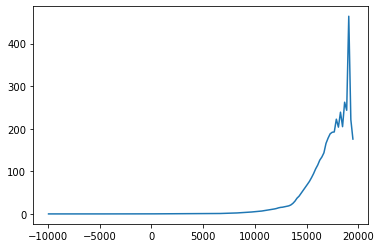

In [299]:
bin_centers,bin_means = bins_slice(qLprime,pr,bins=np.arange(qLprime.min(),qLprime.max(),200))
plt.plot(bin_centers,bin_means)

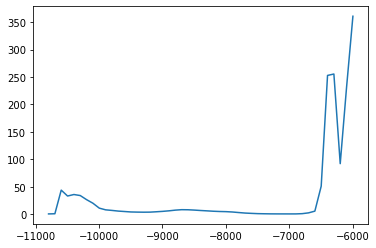

In [303]:
bin_centers,bin_means = bins_slice(TLprime,pr,bins=np.arange(TLprime.min(),TLprime.max(),100))
plt.plot(bin_centers,bin_means)

# Precipitation on rainy times

In [7]:
hrchannelprecip_hourly = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.precip.hourly.days0-200.nc')

## Manually

In [68]:
hrchannelprecip_hov = change_coords_sfc(hrchannelprecip_hourly[-1200:].mean('south_north'))

In [70]:
ts=[(2,17),(29,37),(43,52),(70,85),(102,127),(138,148),(165,173),(182,194),(205,215),(222,236),(258,269),(280,297),(316,328)]#,350,367,412,424]

In [76]:
ts2 = [(17,25),(50,59),(79,94),(110,132),(150,173),(185,192),(200,211),(218,235),(248,282),(305,316),(329,337),(355,369),(385,412),(428,449),(460,471),(490,510),(530,557),(580,591)]

In [78]:
from functools import reduce
def select_hov(t,d):
    return reduce(lambda x,y:x|y,[(t>=600+t1+(d+4902)/36) & (t<=600+t2+(d+4902)/36) for t1,t2 in ts]+[(t>=t1+(d+4902)/36) & (t<=t2+(d+4902)/36) for t1,t2 in ts2])

In [79]:
test=hrchannelprecip_hov.where(select_hov(hrchannelprecip_hov.Time,hrchannelprecip_hov.distance_from_mtn))#hrchannelprecip_hov.Time>2+(hrchannelprecip_hov.distance_from_mtn+4902)/36)

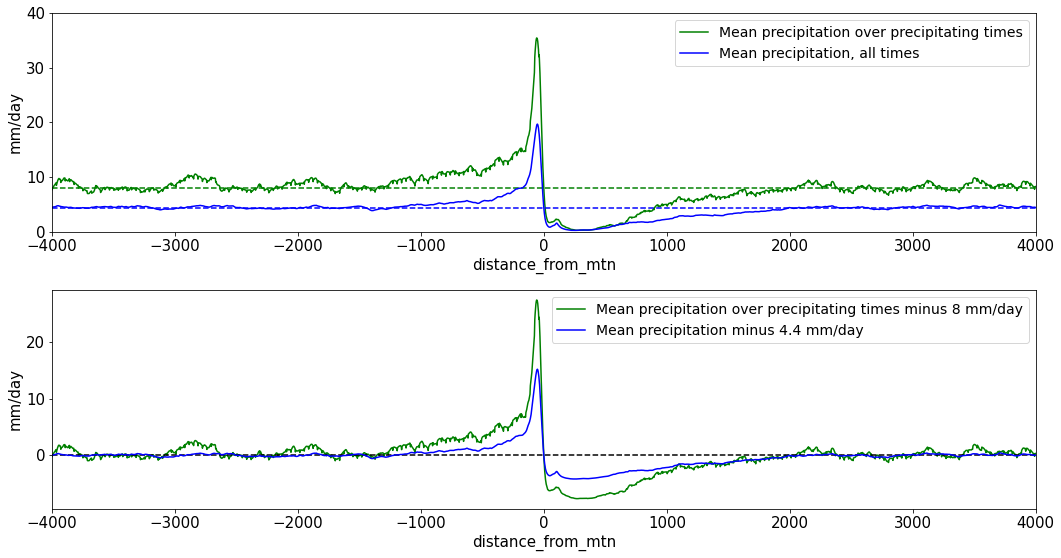

In [109]:
matplotlib.rcParams.update({'font.size':15})
fig,(ax,ax2)=plt.subplots(2,1,figsize=(15,8))

(test.mean('Time')).plot(ax=ax,color='g',label='Mean precipitation over precipitating times')
ax.axhline(8.,color='g',linestyle='--')
ax.axhline(4.4,color='b',linestyle='--')
change_coords_sfc(hrpr).plot(ax=ax,color='b',label='Mean precipitation, all times')
change_coords_sfc(2*hrpr).plot(ax=ax,color='b',label='Mean precipitation, all times')

(test.mean('Time')-8).plot(ax=ax2,color='g',label='Mean precipitation over precipitating times minus 8 mm/day')
ax2.axhline(0.,color='k',linestyle='--')
change_coords_sfc(hrpr-4.5).plot(ax=ax2,color='b',label='Mean precipitation minus 4.4 mm/day')

for a in ax,ax2:
    a.set_xlim(-4000,4000)
    a.set_ylabel('mm/day')
    a.legend(fontsize=14)
ax.set_ylim(0.,40)
fig.tight_layout()

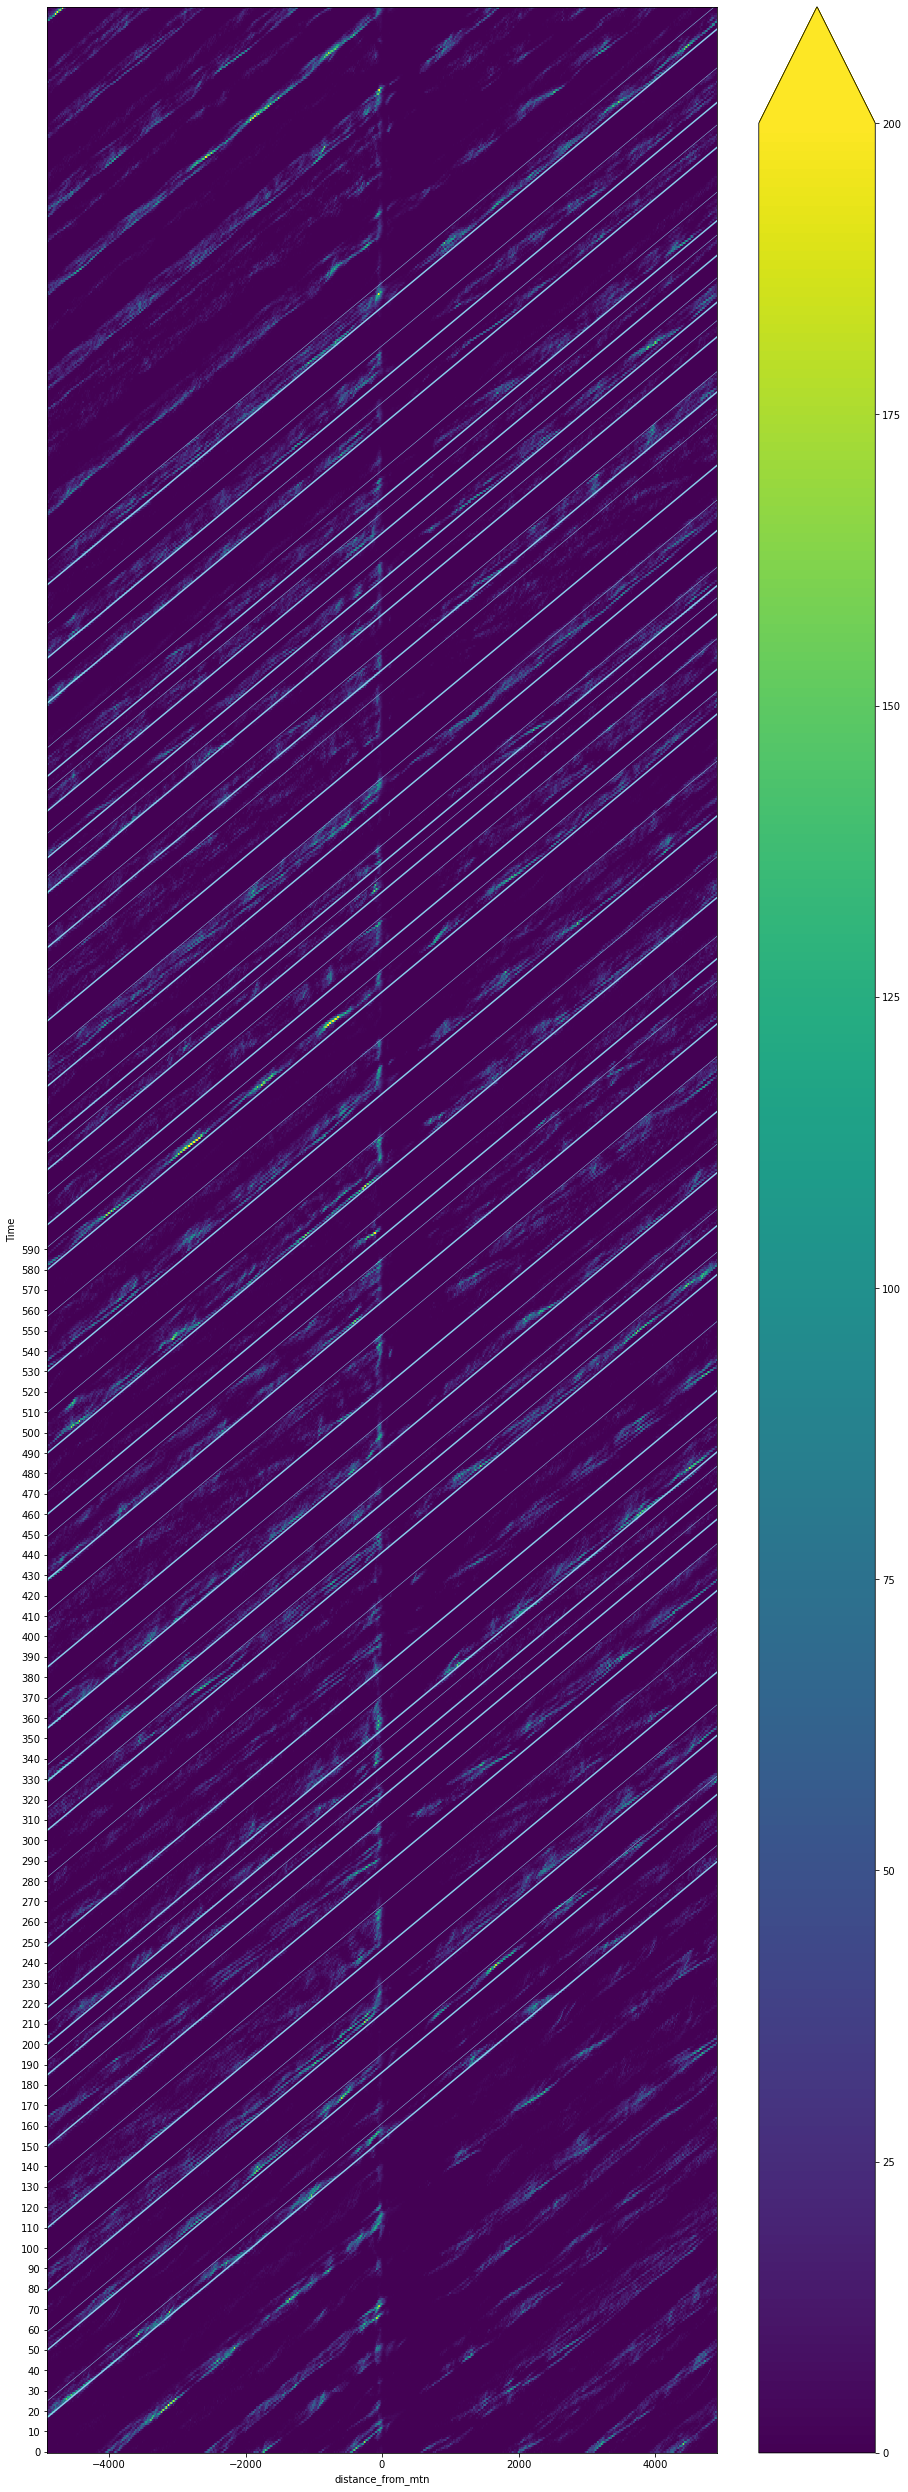

In [82]:
plt.figure(figsize=(15,45))
hrchannelprecip_hov.plot(vmax=200)
for t1,t2 in ts:
    plt.plot(hrchannelprecip_hov.distance_from_mtn,600+t1+(hrchannelprecip_hov.distance_from_mtn+4902)*1000/(10*3600),color='skyblue')
    plt.plot(hrchannelprecip_hov.distance_from_mtn,600+t2+(hrchannelprecip_hov.distance_from_mtn+4902)*1000/(10*3600),color='skyblue',linewidth=0.5)
for t1,t2 in ts2:
    plt.plot(hrchannelprecip_hov.distance_from_mtn,t1+(hrchannelprecip_hov.distance_from_mtn+4902)*1000/(10*3600),color='skyblue')
    plt.plot(hrchannelprecip_hov.distance_from_mtn,t2+(hrchannelprecip_hov.distance_from_mtn+4902)*1000/(10*3600),color='skyblue',linewidth=0.5)

plt.yticks(range(0,600,10));None

## automating

In [132]:
%%time # takes 6 min
hrchannelprecip_hourly = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.precip.hourly.days0-200.nc')
hrchannelprecip_hov_all = change_coords_sfc(hrchannelprecip_hourly[1200:].mean('south_north'))

def select_hov_t(t0,t,d):
    return ((t>=t0-.5+(d+4902)/36) & (t<=t0+.5+(d+4902)/36))

n=len(hrchannelprecip_hov_all.Time)-300
p_charac=np.zeros(n)
for t in range(n):
    if t%25==0:
        print(t,end=' ')
    p_charac[t] = float(hrchannelprecip_hov_all.where(select_hov_t(t,hrchannelprecip_hov_all.Time,hrchannelprecip_hov_all.distance_from_mtn))[t:t+300].mean())

p_charac = xr.DataArray(p_charac,coords={'Time':hrchannelprecip_hov_all.Time[:-300]},dims=['Time'])
p_charac.to_netcdf("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.pcharac.days50-188.nc")

CPU times: user 2.24 s, sys: 6.32 s, total: 8.56 s
Wall time: 9.2 s


In [219]:
p_charac = xr.open_dataarray("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.pcharac.days50-188.nc")

In [220]:
thresh_crossings=np.arange(len(p_charac)-1)[np.diff(p_charac>2)]
ends=thresh_crossings[1::2]+1
begs=thresh_crossings[::2][:len(ends)]


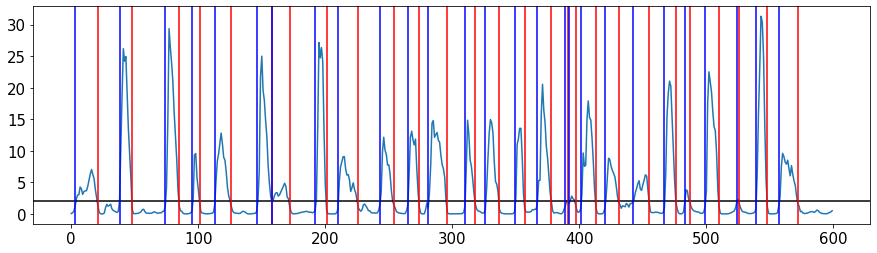

In [179]:
n1,n2=0,600
plt.figure(figsize=(15,4))
plt.plot(p[n1:n2])
plt.axhline(2,color='k')
for b,e in zip(begs,ends):
    if b>n1 and e<n2:
        plt.axvline(b-n1,color='b')
        plt.axvline(e-n1,color='r')

In [180]:
print(np.sum(ends-begs)/3300)

0.4693939393939394


In [198]:
print(np.sum(ends2-begs2)/3300)

0.3609090909090909


In [181]:
1/0.469

2.1321961620469083

In [185]:
from functools import reduce
def select_hov_all(t,d):
    return reduce(lambda x,y:x|y,[(t>=t1+(d+4902)/36) & (t<=t2+(d+4902)/36) for t1,t2 in zip(begs,ends)])

test=hrchannelprecip_hov_all.where(select_hov_all(hrchannelprecip_hov_all.Time,hrchannelprecip_hov_all.distance_from_mtn))

In [204]:
allts2=np.arange(len(p)-1)[np.diff(p>5)]
ends2=allts2[1::2]+1
begs2=allts2[::2][:len(ends2)]
def select_hov_all2(t,d):
    return reduce(lambda x,y:x|y,[(t>=t1+(d+4902)/36) & (t<=t2+(d+4902)/36) for t1,t2 in zip(begs2,ends2)])
test2=hrchannelprecip_hov_all.where(select_hov_all2(hrchannelprecip_hov_all.Time,hrchannelprecip_hov_all.distance_from_mtn))

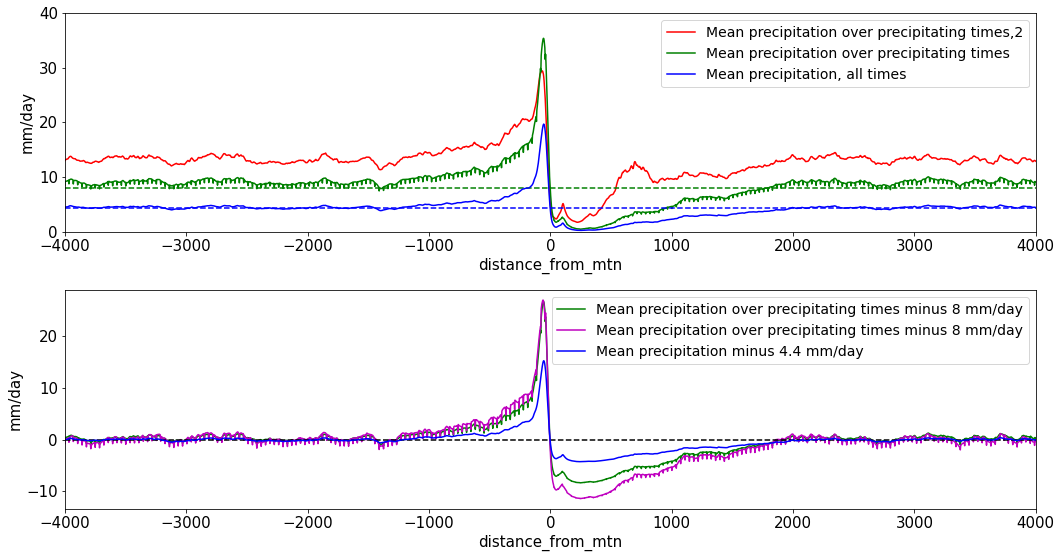

In [209]:
matplotlib.rcParams.update({'font.size':15})
fig,(ax,ax2)=plt.subplots(2,1,figsize=(15,8))

change_coords_sfc(test3).plot(ax=ax,color='r',label='Mean precipitation over precipitating times,2')
(test.mean('Time')).plot(ax=ax,color='g',label='Mean precipitation over precipitating times')
ax.axhline(8.,color='g',linestyle='--')
ax.axhline(4.4,color='b',linestyle='--')
change_coords_sfc(hrpr).plot(ax=ax,color='b',label='Mean precipitation, all times')
#change_coords_sfc(2*hrpr).plot(ax=ax,color='b',label='Mean precipitation, all times')

(test.mean('Time')-8.8).plot(ax=ax2,color='g',label='Mean precipitation over precipitating times minus 8 mm/day')
(test2.mean('Time')-12).plot(ax=ax2,color='m',label='Mean precipitation over precipitating times minus 8 mm/day')
ax2.axhline(0.,color='k',linestyle='--')
change_coords_sfc(hrpr-4.5).plot(ax=ax2,color='b',label='Mean precipitation minus 4.4 mm/day')

for a in ax,ax2:
    a.set_xlim(-4000,4000)
    a.set_ylabel('mm/day')
    a.legend(fontsize=14)
ax.set_ylim(0.,40)
fig.tight_layout()

In [212]:
9810/36/24

11.354166666666666

In [194]:
test.mean('Time').to_netcdf("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.precip.rainymean.days50-200.nc")


In [208]:
test3=hrchannelprecip_hourly[1200:].where(hrchannelprecip_hourly[1200:]>0.).mean(['Time','south_north'])

In [ ]:
test3.plot()